# Library

This chapter contains all the functions that are used in other chapters of the documents. There is the following segregation of functions/classes by topic:
* **Imports** - all the imports and pre-definitions
* **EDA** - the tools for exploration the data nature (i.e. functions for box plot and distribution drawing; NaN and sanity checker, etc) 
* **Feature engineering** - tools for extracting new features out of the data or removing outliers
* **Statistical testing** - tools for testing the hypothesises (i.e. class for t-test or ANOVA)
* **FS interaction** - tools for reading / writing files in FS or merging / separating data structures (i.e. `pd.DataFrame`)

## Imports

In [168]:
import math
from typing import Literal, Union

from IPython.core.display import HTML

# Stat testing
from scipy import stats
from scipy.stats import mannwhitneyu
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Core
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# RE
import re

## EDA tools

This function generates and displays styled HTML tables of summary statistics (`.describe()`) for each group in a DataFrame based on a specified column.

In [169]:
def generate_account_summary_html(df, group_by_column):
    """
    Generates an HTML display of styled summary statistics grouped by a specified column.
    
    - :param df (pd.DataFrame): The input DataFrame.
    - :param group_by_column (str): The column to group by (default: 'account').
    """
    html_blocks = []

    for group_value, group in df.groupby(group_by_column):
        styled = group.describe().style.background_gradient(cmap='Blues').set_table_attributes("style='width:100%;'")
        html = styled.to_html()
        block = f"""
        <div style="flex: 1; padding: 10px;">
            <h3>{group_by_column.capitalize()}: {group_value}</h3>
            {html}
        </div>
        """
        html_blocks.append(block)

    rows = [html_blocks[i:i + 2] for i in range(0, len(html_blocks), 2)]

    html_output = "".join([
        f"<div style='display: flex; gap: 20px; margin-bottom: 30px;'>{''.join(row)}</div>"
        for row in rows
    ])

    display(HTML(html_output))


This function visualizes data points along a line. The position of each point is determined by one feature, and the color is determined by another categorical feature.

In [170]:
def plot_points_colored_by_feature(df, position_columns: list[str], color_column: str,
                                   split_column: str = None, cmap='tab10'):
    """
    Plots one or more horizontal line charts. Each chart shows points along one feature from 'position_columns',
    and the color of each point is based on a categorical 'color_column'.

    Optionally, the data can be split into groups using 'split_column', and subplots will be drawn for each group.

    Parameters:
    - df: pandas.DataFrame
    - position_columns: list[str] — features to plot along the X-axis
    - color_column: str — categorical feature used for color encoding
    - split_column: str — (optional) column name to split DataFrame into groups
    - cmap: str — matplotlib colormap name (default: 'tab10')
    """
    copy_df = df.copy()

    # Prepare color mapping
    color_values = copy_df[color_column].astype(str)
    unique_categories = sorted(color_values.unique())
    
    color_map = {cat: idx for idx, cat in enumerate(unique_categories)}
    copy_df['_color_idx'] = color_values.map(color_map)
    cmap_obj = plt.get_cmap(cmap, len(unique_categories))

    # Handle optional splitting
    groups = copy_df.groupby(split_column) if split_column else [(None, copy_df)]
    num_groups = len(groups)

    n_cols = len(position_columns)
    fig, axes = plt.subplots(num_groups, n_cols, figsize=(6 * n_cols, 4 * num_groups), sharey=True)

    # Ensure axes is 2D for consistent indexing
    if num_groups == 1:
        axes = [axes]  # convert to list of axes
    if n_cols == 1:
        axes = [[ax] for ax in axes]  # convert to 2D array for single-column case

    for row_idx, (group_name, group_df) in enumerate(groups):
        # Set title
        axes[row_idx][0].set_title(group_name.capitalize(), fontweight='bold', fontsize=20)
        
        for col_idx, position_column in enumerate(position_columns):
            ax = axes[row_idx][col_idx]
            x = group_df[position_column]
            y = np.zeros_like(x)

            ax.scatter(
                x, y,
                c=group_df['_color_idx'],
                cmap=cmap_obj,
                s=100,
                alpha=0.7,
                edgecolors='w'
            )

            ax.set_yticks([])
            ax.set_xlabel(position_column, fontsize=11)
            ax.grid(True, linestyle='--', alpha=0.5)
    # Build the legend once, outside loop
    handles = [
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=cmap_obj(idx), markeredgecolor='black',
                   markersize=6)
        for idx in range(len(unique_categories))
    ]
    axes[0][-1].legend(handles, unique_categories, title=color_column,
                       bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


This function produces bar chart shows the count of records for each post type. This visualization helps identify the distribution of content formats (e.g., posts vs. reels) in the dataset. It provides a clear view of how frequently each post type appears.

In [171]:
def plot_category_counts(df: pd.DataFrame, x_cols: list[str]):
    """
    Plots the count of rows per category for each specified categorical column.

    :param df: pd.DataFrame - The input DataFrame.
    :param x_cols: list[str] - List of categorical columns to group by on the x-axis.
    """
    sns.set(style="dark", palette="muted")

    num_plots = len(x_cols)
    ncols = 2
    nrows = math.ceil(num_plots / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 5))

    # Flatten axes to easily iterate
    axes = axes.flatten() if num_plots > 1 else [axes]    
    
    for i, x_col in enumerate(x_cols):
        ax = axes[i]

        # Count and sort categories
        counts = df[x_col].value_counts().sort_index()

        sns.barplot(x=counts.index, y=counts.values, ax=ax, hue=counts.index)

        ax.set_title(f"Count of rows by {x_col}")
        ax.set_xlabel(x_col)
        ax.set_ylabel("Count")

        # Add value labels above bars
        for j, value in enumerate(counts.values):
            ax.text(j, value + max(counts.values) * 0.01, str(value), ha='center', va='bottom', fontsize=10)
            
    # Hide unused subplots
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

The following bar charts compare the average of provided columns. The error bars represent 95% confidence intervals for the mean values. This visualization helps identify engagement differences between the two formats.


In [172]:
def plot_grouped_feature_bars(
        df: pd.DataFrame,
        x_cols: list[str],
        features: list[str],
        estimator: Literal['mean', 'sum'] = 'mean',
        color_feature: str = None
):
    """
    Plots bar charts for multiple numeric features grouped by one or more categorical columns,
    using the specified aggregation method. One row per x_col, one column per feature.

    :param df: pd.DataFrame - The input DataFrame.
    :param x_cols: list[str] - Categorical columns to group by on the x-axis.
    :param features: list[str] - Numeric features to aggregate.
    :param estimator: str - Aggregation method: 'mean' or 'sum'.
    :param color_feature: str - The categorical column to define the color and split the columns (optional)
    """
    sns.set(style="dark", palette="muted")

    # Map string to function
    if estimator == 'mean':
        estimator_func = np.mean
    elif estimator == 'sum':
        estimator_func = np.sum
    else:
        raise ValueError("Invalid estimator. Choose 'mean' or 'sum'.")

    n_rows = len(x_cols)
    n_cols = len(features)

    # Create grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 5 * n_rows))

    # Ensure axes is always 2D (e.g., if 1 row or 1 column)
    if n_rows == 1 and n_cols == 1:
        axes = [[axes]]
    elif n_rows == 1:
        axes = [axes]
    elif n_cols == 1:
        axes = [[ax] for ax in axes]

    # Loop over x_cols and features to fill subplots
    for i, x_col in enumerate(x_cols):
        for j, feature in enumerate(features):
            ax = axes[i][j]
            sns.barplot(
                data=df,
                x=x_col,
                y=feature,
                hue=color_feature if color_feature else x_col,
                palette="deep",
                estimator=estimator_func,
                errorbar=None if estimator == 'sum' else ('ci', 95),
                ax=ax,
            )
            ax.set_title(f"{estimator} of {feature} by {x_col}")
            ax.set_xlabel(x_col)
            ax.set_ylabel(f"{estimator} of {feature}")

    # Add column titles above each column
    for j, feature in enumerate(features):
        fig.text(
            x=(j + 0.5) / n_cols,
            y=1.02,
            s=feature.replace('_', ' ').capitalize(),
            ha='center',
            va='bottom',
            fontsize=14,
            weight='bold'
        )

    plt.tight_layout()
    plt.show()


This function analyze DataFrame columns to identify and summarize non-numeric values.

In [173]:
def count_non_number_values(df: pd.DataFrame, feature_list: list) -> pd.DataFrame:
    """
    Analyzes specified columns in a pandas DataFrame to detect non-numeric values 
    (i.e., values that are not of type int or float). For each column, the function 
    provides example non-numeric entries, their count, and their relative frequency.

    :param df: A pandas DataFrame containing the dataset.
    :param feature_list: A list of column names (features) to evaluate.
    :return: A pandas DataFrame summarizing the count and frequency of non-numeric values 
             per specified column, along with a few example values.
    """

    # Dictionary to store results for each specified feature/column
    results = {}

    # Loop over each feature in the provided list
    for col in feature_list:
        # Proceed only if the column exists in the DataFrame
        if col in df.columns:
            # Identify values in the column that are NOT integers or floats
            non_int_values = df[col][df[col].apply(lambda x: not isinstance(x, (int, float)))]

            # Store the analysis results for the current column
            results[col] = {
                # Collect up to 5 unique examples of non-numeric values
                "Examples": non_int_values.unique()[:5],

                # Count of non-numeric entries in the column
                "Non-Int Count": non_int_values.shape[0],

                # Relative frequency (%) of non-numeric values in the column
                "Relative frequency": f"{round(non_int_values.shape[0] / df[col].shape[0] * 100, 2)}%",
            }

    # Convert the results dictionary to a DataFrame, using feature names as the index
    return pd.DataFrame.from_dict(results, orient="index")

This function plots boxplots for a user-specified list of numeric features from a DataFrame, validating that all selected columns exist and are of numeric type.

In [174]:
def plot_boxplots(df: pd.DataFrame, numerical_features: list[str],
                  split_feature: str = None, internal_split_feature: str = None):
    """
    Plots boxplots for the specified numeric features.
    Supports splitting across multiple figures by 'split_feature',
    and internal grouping within plots by 'internal_split_feature'.

    - :param df: DataFrame with the data
    - :param numerical_features: list of numeric column names to plot
    - :param split_feature: optional column to split into multiple figures
    - :param internal_split_feature: optional column to group boxplots within each subplot

    - :raises ValueError if features are missing or non-numeric
    """
    # Validation
    missing = [col for col in numerical_features if col not in df.columns]
    if missing:
        raise ValueError(f"The following features are missing: {missing}")

    non_numeric = [col for col in numerical_features if not np.issubdtype(df[col].dtype, np.number)]
    if non_numeric:
        raise ValueError(f"The following features are not numeric: {non_numeric}")

    # Handle splitting into figures
    groups = df.groupby(split_feature) if split_feature else [(None, df)]

    for group_name, group_df in groups:
        num_cols = len(numerical_features)
        num_rows = (num_cols + 1) // 2
        fig, axes = plt.subplots(num_rows, 2 if not internal_split_feature else 1, figsize=(
            14, 5 * num_rows * (df[split_feature].nunique() if internal_split_feature else 1)))

        axes = axes.flatten() if not internal_split_feature else axes

        for i, col in enumerate(numerical_features):
            ax = axes[i] if not internal_split_feature else axes

            if internal_split_feature:
                sns.boxplot(
                    data=group_df,
                    x=internal_split_feature,
                    y=col,
                    ax=ax,
                    hue=internal_split_feature,
                    flierprops={'marker': 'o', 'color': 'red', 'markersize': 5}
                )
                ax.set_xlabel(internal_split_feature)
            else:
                sns.boxplot(
                    y=group_df[col],
                    ax=ax,
                    color='skyblue',
                    width=0.4,
                    flierprops={'marker': 'o', 'color': 'red', 'markersize': 5}
                )
                ax.set_xlabel('')

            ax.set_ylabel(col)

        # Remove unused axes
        for i in range(len(numerical_features), len(axes) if not internal_split_feature else 1):
            fig.delaxes(axes[i])

        # Optional title per figure if split
        if group_name is not None:
            fig.suptitle(f"{group_name.capitalize()}", fontsize=24, fontweight='bold')

        plt.tight_layout()
        plt.show()


This function plots multiple distributions from a dictionary of NumPy arrays using KDE (Kernel Density Estimation)

In [175]:
def plot_distributions(
        data: dict[str, np.array],
        xlabel: str,
        ylabel: str,
        title: str,
):
    """
    Plots multiple distributions from a dictionary of arrays using KDE approximation on the same graph.

    :param data: dict — Dictionary where keys are group names and values are NumPy arrays of numeric values.
    :param xlabel: str — Label for the X-axis.
    :param ylabel: str — Label for the Y-axis.
    :param title: str — Title of the plot.
    """
    plt.figure(figsize=(10, 6))

    # Iterate over each group and plot its KDE distribution
    for label, values in data.items():
        values = np.array(values)

        sns.kdeplot(
            values,
            label=label,
            fill=True,
            bw_adjust=1.0
        )

    # Set custom labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=14)
    plt.legend(title="Group")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


    ## Feature engineering tools

The function removes outliers using **quantile method** (IQR)

In [176]:
def remove_outliers_by_quantile(data: pd.DataFrame, features):
    """
    Removes outliers from a DataFrame using the Interquartile Range (IQR) method for specified features.

    :param data: pd.DataFrame - The input DataFrame.
    :param features: list - A list of column names (features) on which to apply outlier removal.
    :return: pd.DataFrame - A DataFrame with outliers removed based on the specified features.
    """
    for feature in features:
        # First quartile (25th percentile)
        Q1 = data[feature].quantile(0.25)

        # Third quartile (75th percentile)
        Q3 = data[feature].quantile(0.75)

        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # Lower bound for acceptable values
        lower_bound = Q1 - 1.5 * IQR

        # Upper bound for acceptable values
        upper_bound = Q3 + 1.5 * IQR

        # Filter out rows with feature values outside the bounds
        data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]

    # Return the filtered DataFrame
    return data


This function checks if a message contains any personal words from a predefined set.

In [177]:
def contains_personal_words(text: str, personal_words: set[str]):
    """
    Determines whether the input text contains any personal words
    from the predefined set PERSONAL_WORDS.

    :param personal_words: set of personal words
    :param text: The input string (e.g., a message or comment).
    :return: True if at least one personal word is present, False otherwise.
    """
    words = set(str(text).lower().split())
    return not personal_words.isdisjoint(words)

This function creates a boolean feature indicating whether the message contains a mention of the given account.

In [178]:
def extract_mention_match(message: str, account: str) -> bool:
    """
    Checks if the message contains any @mention that does NOT match the given account.

    :param message: Text message that may contain @mentions.
    :param account: Target account name to match against mentions.

    :returns True if any mention matches the account name (case-insensitive), False otherwise.
    """
    # Extract all words that follow the @ symbol (e.g., @username)
    mentions = re.findall(r'@(\w+)', message)

    # Compare each mention to the account (case-insensitive)
    return any(m.lower() != account.lower() for m in mentions)

## Statistical testing tools

Following class functionality:
1. This class performs statistical hypothesis testing between two numerical samples.
2. It automatically chooses between a **T-test** and **Mann-Whitney U test** based on normality and variance checks.

In [179]:
class TwoSampleStatisticalTests:
    def __init__(self, first_dataset: pd.Series, second_dataset: pd.Series, significance_level: float):
        """
        Initialize the class with two datasets and a significance level.

        :param first_dataset: First sample (pandas Series)
        :param second_dataset: Second sample (pandas Series)
        :param significance_level: Alpha threshold for hypothesis testing (e.g., 0.05)
        """
        self._first_dataset = first_dataset
        self._second_dataset = second_dataset
        self._significance_level = significance_level

    def _check_normality(self) -> bool:
        """
        Test for normal distribution using Shapiro-Wilk’s test.

        H0: The data is normally distributed  
        Ha: The data is not normally distributed

        :return: True if both datasets are normally distributed, else False
        """
        _, pvalue_first = stats.shapiro(self._first_dataset) if len(self._first_dataset) <= 5000 else stats.normaltest(
            self._first_dataset)
        _, pvalue_second = stats.shapiro(self._second_dataset) if len(
            self._second_dataset) <= 5000 else stats.normaltest(self._second_dataset)

        print(f"The result of the p-value when checking the normality for the first dataset: {pvalue_first}")
        print(f"The result of the p-value when checking the normality for the second dataset: {pvalue_second}")

        return pvalue_first >= self._significance_level and pvalue_second >= self._significance_level

    def _check_variance_homogeneity(self) -> bool:
        """
        Test for homogeneity of variances using Levene's test.

        H0: Variances are equal (homogeneous)  
        Ha: Variances are different

        :return: True if variances are equal, else False
        """
        _, pvalue = stats.levene(self._first_dataset, self._second_dataset)

        print(f"The result of the p-value when checking the variance uniform: {pvalue}")

        return pvalue >= self._significance_level

    def _t_test(self, is_one_tailed: bool = False) -> float:
        """
        Perform an independent two-sample T-test assuming equal variances.

        :param is_one_tailed: If True, calculates one-tailed p-value.
        :return: p-value from T-test
        """
        t_stat, p_value = stats.ttest_ind(self._first_dataset, self._second_dataset, equal_var=True)

        # Adjust for one-tailed test if requested
        return p_value if not is_one_tailed else (p_value / 2 if t_stat > 0 else 1 - (p_value / 2))

    def _mann_whitney_test(self, is_one_tailed: bool = False) -> float:
        """
        Perform the Mann-Whitney U test (non-parametric alternative to T-test).

        :param is_one_tailed: If True, uses 'greater' alternative.
        :return: p-value from Mann-Whitney test
        """
        alternative = 'greater' if is_one_tailed else 'two-sided'
        _, p_value = mannwhitneyu(self._first_dataset, self._second_dataset, alternative=alternative)
        return p_value

    def test_two_numerical_samples(self, is_one_tailed: bool = False):
        """
        Runs the appropriate hypothesis test between two numerical samples.

        - If both samples are normally distributed AND variances are equal: T-test is used  
        - Otherwise: Mann-Whitney U test is used

        Prints the test used, the final p-value, and the hypothesis decision.
        """
        # Step 1: Check distribution
        is_normally_distributed = self._check_normality()

        # Step 2: Check variance homogeneity
        is_variance_homogeneous = self._check_variance_homogeneity()

        # Step 3: Choose test based on assumptions
        if is_normally_distributed and is_variance_homogeneous:
            print("T-test was chosen")
            p_value = self._t_test(is_one_tailed)
        else:
            print("Mann-Whitney was chosen")
            p_value = self._mann_whitney_test(is_one_tailed)

        # Step 4: Report results
        print(f"Final p-value: {p_value}")

        if p_value <= self._significance_level:
            print("H0 has been rejected, Ha has been accepted")
        else:
            print("H0 was not rejected")

Following class functionality:
- Automatically check assumptions (normality and homogeneity)
- Run ANOVA or Kruskal-Wallis according
- Clearly report the chosen test, p-value, and hypothesis decision

In [180]:
class MultipleSampleStatisticalTests:
    def __init__(self, datasets: list[pd.Series], significance_level: float):
        """
        Initialize with multiple datasets and a significance level.

        :param datasets: A list of independent numerical samples (pandas Series)
        :param significance_level: Alpha threshold for hypothesis testing (e.g., 0.05)
        """
        self._datasets = datasets
        self._significance_level = significance_level
        self._df = self._prepare_dataframe()

    def _prepare_dataframe(self) -> pd.DataFrame:
        """
        Combine all datasets into one DataFrame with 'value' and 'group' columns.
        """
        data = []
        for idx, series in enumerate(self._datasets):
            group_label = f'Group{idx + 1}'
            data.extend(zip(series, [group_label] * len(series)))
        df = pd.DataFrame(data, columns=['value', 'group'])
        return df

    def _check_normality_residuals(self) -> bool:
        """
        Check if residuals from ANOVA model are normally distributed.

        H0: Residuals are normally distributed  
        Ha: Residuals are not normally distributed

        :return: True if residuals are normal, else False
        """
        model = smf.ols('value ~ C(group)', data=self._df).fit()
        residuals = model.resid

        if len(residuals) <= 5000:
            _, pvalue = stats.shapiro(residuals)
        else:
            _, pvalue = stats.normaltest(residuals)

        print(f"Normality p-value (residuals): {pvalue}")
        return pvalue >= self._significance_level

    def _check_variance_homogeneity(self) -> bool:
        """
        Check for equal variances using Levene’s test.

        H0: Variances are equal (homogeneous)  
        Ha: Variances are different

        :return: True if variances are equal, else False
        """
        group_values = [group['value'].values for _, group in self._df.groupby('group')]
        _, pvalue = stats.levene(*group_values)
        print(f"Variance homogeneity p-value: {pvalue}")
        return pvalue >= self._significance_level

    def _anova_test(self) -> float:
        """
        Perform one-way ANOVA using statsmodels.

        :return: p-value from ANOVA
        """
        model = smf.ols('value ~ C(group)', data=self._df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        pvalue = anova_table["PR(>F)"].iloc[0]
        return pvalue

    def _kruskal_wallis_test(self) -> float:
        """
        Perform Kruskal-Wallis H-test for independent samples.

        :return: p-value from Kruskal-Wallis test
        """
        group_values = [group['value'].values for _, group in self._df.groupby('group')]
        _, pvalue = stats.kruskal(*group_values)
        return pvalue

    def test_multiple_samples(self):
        """
        Run the appropriate hypothesis test between multiple numerical samples.

        - If residuals from ANOVA are normally distributed AND variances are equal: use ANOVA  
        - Otherwise: use Kruskal-Wallis

        Prints the test used, the final p-value, and the hypothesis decision.
        """
        is_normal = self._check_normality_residuals()
        is_homogeneous = self._check_variance_homogeneity()

        if is_normal and is_homogeneous:
            print("ANOVA test was chosen")
            p_value = self._anova_test()
        else:
            print("Kruskal-Wallis test was chosen")
            p_value = self._kruskal_wallis_test()

        print(f"Final p-value: {p_value}")

        if p_value <= self._significance_level:
            print("H0 has been rejected, Ha has been accepted")
        else:
            print("H0 was not rejected")


## Dataframe interaction tools

This function extract series based on the target feature and split feature

In [181]:
def extract_target_feature(df, split_feature, target_feature):
    """
    Extracts values of the target feature from the DataFrame,
    grouped by the unique values of the split feature.

    :param df: pandas.DataFrame — The input dataset.
    :param split_feature: str — Column name to group by (e.g., 'account').
    :param target_feature: str — Column name whose values are extracted (e.g., 'likes').
    
    :return: dict — A dictionary where keys are unique values of split_feature,
                    and values are NumPy arrays of corresponding target_feature values.
    """
    result = {}

    # Iterate over each unique value in the split feature column
    for feature in df[split_feature].unique():
        # Filter rows where split_feature == current group
        # and extract the values of the target feature
        result[feature] = df[df[split_feature] == feature][target_feature].values

    return result

This function standardizes DataFrame column names by converting them to lowercase and replacing spaces and hyphens with underscores, making them easier to work with in code

In [182]:
def clean_column_names(df):
    """
    Converts column names to lowercase and replaces spaces and hyphens with underscores.

    :param df: A pandas DataFrame with original column names.
    :return: DataFrame with cleaned column names.
    """
    df = df.copy()
    df.columns = (
        df.columns
        .str.lower()  # Convert all column names to lowercase
        .str.replace(' ', '_', regex=False)  # Replace spaces with underscores
        .str.replace('-', '_', regex=False)  # Replace hyphens with underscores
        .str.replace(r',|&', '', regex=True)  # Replace commas and ampersands
        .str.replace(r'_+', '_', regex=True)  # Replace duplicates
    )
    return df

Reading dataset from **xlsx**

In [183]:
def read_dataset(brand_name: str, folder: str):
    df = pd.read_excel(f'./data/{folder}/{brand_name}.xlsx')
    return df

# Reading datasets

Defining the folders names

In [184]:
INTERNATIONAL_TYPE = "international"
LOCAL_TYPE = "local"

Defining the datasets names for **international** and **local** companies

In [185]:
INTERNATIONAL_COMPANIES = ['@corendon.nl', '@vakantiediscounter', '@prijsvrijvakanties', '@sunweb', '@tuinederland',
                           '@dreizenvakanties', '@elizawashere']

LOCAL_COMPANIES = ['@accessibletravelnetherlands', '@cherrytraveltours', '@hollandtravel', '@lvtravelagency',
                   '@tomstraveltours', '@tenzing_travel', '@cruisetravelnl']

Read **local** datasets into list of pd.DataFrame

In [186]:
local_companies_dfs = []

for brand_name in LOCAL_COMPANIES:
    current_df = read_dataset(brand_name, LOCAL_TYPE)
    current_df['account'] = brand_name
    current_df['type'] = LOCAL_TYPE

    local_companies_dfs.append(current_df)

local_companies_dfs[0]

,Date,Message,Profile,Network,Engagement,Post interaction rate,Number of comments,"Reactions, Comments & Shares",Number of Likes,Message-ID,Profile-ID,Link,account,type
0,2025-03-01 09:04:43,Discover Nijmegen: The Oldest City in the Neth...,Accessible Travel Netherlands,INSTAGRAM,0.008539,0.008539,0,9,9,18052737773131838,43939331,https://www.instagram.com/p/DGpqqf8o9yE/,@accessibletravelnetherlands,local
1,2025-02-05 11:14:13,Amsterdam should be at the top of your travel ...,Accessible Travel Netherlands,INSTAGRAM,-,-,1,26,25,18101839216492258,43939331,https://www.instagram.com/p/DFsGZ3voYrG/,@accessibletravelnetherlands,local
2,2025-01-31 15:32:04,The Veluwe ❤️\n\nExplore one of the most stunn...,Accessible Travel Netherlands,INSTAGRAM,-,-,0,5,5,18090951523529057,43939331,https://www.instagram.com/p/DFfr8IVoPZf/,@accessibletravelnetherlands,local
3,2025-01-29 16:31:20,Experience the Traditional Gouda Cheese Market...,Accessible Travel Netherlands,INSTAGRAM,-,-,0,9,9,18060269164931558,43939331,https://www.instagram.com/p/DFapIbBoaj7/,@accessibletravelnetherlands,local
4,2025-01-26 16:20:51,"At Accessible Travel Netherlands, we offer 10 ...",Accessible Travel Netherlands,INSTAGRAM,-,-,0,5,5,18051201320326350,43939331,https://www.instagram.com/p/DFS5jAbIHIC/,@accessibletravelnetherlands,local
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,2013-02-19 16:40:03,#deventer #old #historic #city feels like #eng...,Accessible Travel Netherlands,INSTAGRAM,-,-,0,3,3,17842589947035332,43939331,https://www.instagram.com/p/V62rePw7Ge/,@accessibletravelnetherlands,local
203,2013-01-28 13:31:25,At the #oldest #neigbourhood of #panama #city,Accessible Travel Netherlands,INSTAGRAM,-,-,0,6,6,17842581193035332,43939331,https://www.instagram.com/p/VB3mrKw7J4/,@accessibletravelnetherlands,local
204,2012-12-16 20:38:32,"Ons nieuwe huis op Senidup, Archipela de San B...",Accessible Travel Netherlands,INSTAGRAM,-,-,0,2,2,17842564546035332,43939331,https://www.instagram.com/p/TT6TXvQ7PQ/,@accessibletravelnetherlands,local
205,2012-07-18 23:15:16,NaN,Accessible Travel Netherlands,INSTAGRAM,-,-,0,0,0,17842437124035332,43939331,https://www.instagram.com/p/NPYNL_w7LO/,@accessibletravelnetherlands,local


Join the datasets together into one **Dataframe** and save it

In [187]:
local_df = pd.concat(local_companies_dfs, axis=0)
local_df.to_excel(f'./data/{LOCAL_TYPE}.xlsx', index=False)

local_df

,Date,Message,Profile,Network,Engagement,Post interaction rate,Number of comments,"Reactions, Comments & Shares",Number of Likes,Message-ID,Profile-ID,Link,account,type
0,2025-03-01 09:04:43,Discover Nijmegen: The Oldest City in the Neth...,Accessible Travel Netherlands,INSTAGRAM,0.008539,0.008539,0,9,9,18052737773131838,43939331,https://www.instagram.com/p/DGpqqf8o9yE/,@accessibletravelnetherlands,local
1,2025-02-05 11:14:13,Amsterdam should be at the top of your travel ...,Accessible Travel Netherlands,INSTAGRAM,-,-,1,26,25,18101839216492258,43939331,https://www.instagram.com/p/DFsGZ3voYrG/,@accessibletravelnetherlands,local
2,2025-01-31 15:32:04,The Veluwe ❤️\n\nExplore one of the most stunn...,Accessible Travel Netherlands,INSTAGRAM,-,-,0,5,5,18090951523529057,43939331,https://www.instagram.com/p/DFfr8IVoPZf/,@accessibletravelnetherlands,local
3,2025-01-29 16:31:20,Experience the Traditional Gouda Cheese Market...,Accessible Travel Netherlands,INSTAGRAM,-,-,0,9,9,18060269164931558,43939331,https://www.instagram.com/p/DFapIbBoaj7/,@accessibletravelnetherlands,local
4,2025-01-26 16:20:51,"At Accessible Travel Netherlands, we offer 10 ...",Accessible Travel Netherlands,INSTAGRAM,-,-,0,5,5,18051201320326350,43939331,https://www.instagram.com/p/DFS5jAbIHIC/,@accessibletravelnetherlands,local
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,2019-08-23 09:39:08,Heeft u mooie foto’s van uw eigen cruise gemaa...,Cruise Travel,INSTAGRAM,-,-,0,22,22,17868232276456526,5621753329,https://www.instagram.com/p/B1gHPoyCygq/,@cruisetravelnl,local
180,2019-07-15 14:54:46,Onze ambassadeur Henk van der Noort heeft een ...,Cruise Travel,INSTAGRAM,-,-,2,26,24,17847898231507730,5621753329,https://www.instagram.com/p/Bz8QXReChhs/,@cruisetravelnl,local
181,2019-07-01 10:31:44,Onze ambassadeur A. Prevo ging aan boord van d...,Cruise Travel,INSTAGRAM,-,-,0,23,23,18079004770055863,5621753329,https://www.instagram.com/p/BzXvIioiGI2/,@cruisetravelnl,local
182,2019-06-20 08:12:23,Verschillende reisbureaus op avontuur naar Ala...,Cruise Travel,INSTAGRAM,-,-,3,49,46,18049625401089614,5621753329,https://www.instagram.com/p/By7KcTpiXN4/,@cruisetravelnl,local


Read **international** datasets into list of pd.DataFrame

In [188]:
international_companies_dfs = []

for brand_name in INTERNATIONAL_COMPANIES:
    current_df = read_dataset(brand_name, INTERNATIONAL_TYPE)
    current_df['account'] = brand_name
    current_df['type'] = INTERNATIONAL_TYPE

    international_companies_dfs.append(current_df)

international_companies_dfs[0]

,Date,Message,Profile,Network,Engagement,Post interaction rate,Number of comments,"Reactions, Comments & Shares",Number of Likes,Message-ID,Profile-ID,Link,account,type
0,2025-03-17 19:01:17,??Ontvang nu extra vroegboekkorting tot €200 é...,Corendon,INSTAGRAM,0.001174,0.001174,3,185,182,18038388467208858,1466583220,https://www.instagram.com/reel/DHT7mD7PW0A/,@corendon.nl,international
1,2025-03-16 14:00:14,"Zon, zee en eindeloze siesta’s… ????☀️ In Span...",Corendon,INSTAGRAM,0.000584,0.000584,0,92,92,18039075278448488,1466583220,https://www.instagram.com/p/DHQ0Zedsckb/,@corendon.nl,international
2,2025-03-16 09:00:39,"☀️ Welkom bij Voyage Belek Golf & Spa, waar ee...",Corendon,INSTAGRAM,0.000838,0.000838,1,132,131,18085134403543445,1466583220,https://www.instagram.com/reel/DHQSGJMB3Nl/,@corendon.nl,international
3,2025-03-15 09:00:32,Hotel Diamond Excellence Resort & Spa in Side ...,Corendon,INSTAGRAM,0.001041,0.001041,0,164,164,17842557165447487,1466583220,https://www.instagram.com/p/DHNtTrRsRIj/,@corendon.nl,international
4,2025-03-14 13:01:48,Last-Minute Deal: €70 Korting op het Ladies of...,Corendon,INSTAGRAM,0.001612,0.001612,5,254,249,18046848881361680,1466583220,https://www.instagram.com/p/DHLkIA1sQxy/,@corendon.nl,international
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,2014-09-29 06:40:40,Morning! Zin in een #Grieks ontbijtje. Vlieg t...,Corendon Vliegvakanties,INSTAGRAM,-,-,7,111,104,820010076175750530_1466583220,1466583220,https://www.instagram.com/p/thQtHWslWC/,@corendon.nl,international
2546,2014-09-11 12:23:14,Nu online op www.girlslove2travel.com het vers...,Corendon,INSTAGRAM,-,-,1,77,76,17841752296023221,1466583220,https://www.instagram.com/p/szhmZnMlUM/,@corendon.nl,international
2547,2014-09-11 12:23:14,Nu online op www.girlslove2travel.com het vers...,Corendon Vliegvakanties,INSTAGRAM,-,-,1,77,76,807136532605588748_1466583220,1466583220,https://www.instagram.com/p/szhmZnMlUM/,@corendon.nl,international
2548,2014-09-10 11:18:41,This is truly one of the nicest beaches around...,Corendon,INSTAGRAM,-,-,9,111,102,17841752305023221,1466583220,https://www.instagram.com/p/sw1atpMlV4/,@corendon.nl,international


Join the datasets together into one **Dataframe** and save it

In [189]:
international_df = pd.concat(international_companies_dfs, axis=0)
international_df.to_excel(f'./data/{INTERNATIONAL_TYPE}.xlsx', index=False)

international_df

,Date,Message,Profile,Network,Engagement,Post interaction rate,Number of comments,"Reactions, Comments & Shares",Number of Likes,Message-ID,Profile-ID,Link,account,type
0,2025-03-17 19:01:17,??Ontvang nu extra vroegboekkorting tot €200 é...,Corendon,INSTAGRAM,0.001174,0.001174,3,185,182,18038388467208858,1466583220,https://www.instagram.com/reel/DHT7mD7PW0A/,@corendon.nl,international
1,2025-03-16 14:00:14,"Zon, zee en eindeloze siesta’s… ????☀️ In Span...",Corendon,INSTAGRAM,0.000584,0.000584,0,92,92,18039075278448488,1466583220,https://www.instagram.com/p/DHQ0Zedsckb/,@corendon.nl,international
2,2025-03-16 09:00:39,"☀️ Welkom bij Voyage Belek Golf & Spa, waar ee...",Corendon,INSTAGRAM,0.000838,0.000838,1,132,131,18085134403543445,1466583220,https://www.instagram.com/reel/DHQSGJMB3Nl/,@corendon.nl,international
3,2025-03-15 09:00:32,Hotel Diamond Excellence Resort & Spa in Side ...,Corendon,INSTAGRAM,0.001041,0.001041,0,164,164,17842557165447487,1466583220,https://www.instagram.com/p/DHNtTrRsRIj/,@corendon.nl,international
4,2025-03-14 13:01:48,Last-Minute Deal: €70 Korting op het Ladies of...,Corendon,INSTAGRAM,0.001612,0.001612,5,254,249,18046848881361680,1466583220,https://www.instagram.com/p/DHLkIA1sQxy/,@corendon.nl,international
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626,2014-08-05 09:33:06,Beleef jij deze zomer een ultiem #elizamomentj...,Eliza was here,INSTAGRAM,-,-,5,20,15,17842862974034381,1258146380,https://www.instagram.com/p/rT8t-nlZRg/,@elizawashere,international
1627,2014-08-04 16:54:05,Lig jij deze zomer hier? Je hebt nog tot morge...,Eliza was here,INSTAGRAM,-,-,4,19,15,17841991168034381,1258146380,https://www.instagram.com/p/rSKY5wFZcT/,@elizawashere,international
1628,2014-07-30 17:08:00,Puur genieten op een ligbedje bij het zwembad....,Eliza was here,INSTAGRAM,-,-,1,16,15,17842038979034381,1258146380,https://www.instagram.com/p/rFUAgoFZV-/,@elizawashere,international
1629,2014-07-29 16:28:38,"Ken je dat gevoel? Je haren in de wind, je voe...",Eliza was here,INSTAGRAM,-,-,9,22,13,17841828277034381,1258146380,https://www.instagram.com/p/rCqtQHlZRN/,@elizawashere,international


Join all the datasets and save **final** dataset

In [190]:
final_df = pd.concat([international_df, local_df], axis=0)
final_df.to_excel("./final.xlsx", index=False)

final_df

,Date,Message,Profile,Network,Engagement,Post interaction rate,Number of comments,"Reactions, Comments & Shares",Number of Likes,Message-ID,Profile-ID,Link,account,type
0,2025-03-17 19:01:17,??Ontvang nu extra vroegboekkorting tot €200 é...,Corendon,INSTAGRAM,0.001174,0.001174,3,185,182,18038388467208858,1466583220,https://www.instagram.com/reel/DHT7mD7PW0A/,@corendon.nl,international
1,2025-03-16 14:00:14,"Zon, zee en eindeloze siesta’s… ????☀️ In Span...",Corendon,INSTAGRAM,0.000584,0.000584,0,92,92,18039075278448488,1466583220,https://www.instagram.com/p/DHQ0Zedsckb/,@corendon.nl,international
2,2025-03-16 09:00:39,"☀️ Welkom bij Voyage Belek Golf & Spa, waar ee...",Corendon,INSTAGRAM,0.000838,0.000838,1,132,131,18085134403543445,1466583220,https://www.instagram.com/reel/DHQSGJMB3Nl/,@corendon.nl,international
3,2025-03-15 09:00:32,Hotel Diamond Excellence Resort & Spa in Side ...,Corendon,INSTAGRAM,0.001041,0.001041,0,164,164,17842557165447487,1466583220,https://www.instagram.com/p/DHNtTrRsRIj/,@corendon.nl,international
4,2025-03-14 13:01:48,Last-Minute Deal: €70 Korting op het Ladies of...,Corendon,INSTAGRAM,0.001612,0.001612,5,254,249,18046848881361680,1466583220,https://www.instagram.com/p/DHLkIA1sQxy/,@corendon.nl,international
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,2019-08-23 09:39:08,Heeft u mooie foto’s van uw eigen cruise gemaa...,Cruise Travel,INSTAGRAM,-,-,0,22,22,17868232276456526,5621753329,https://www.instagram.com/p/B1gHPoyCygq/,@cruisetravelnl,local
180,2019-07-15 14:54:46,Onze ambassadeur Henk van der Noort heeft een ...,Cruise Travel,INSTAGRAM,-,-,2,26,24,17847898231507730,5621753329,https://www.instagram.com/p/Bz8QXReChhs/,@cruisetravelnl,local
181,2019-07-01 10:31:44,Onze ambassadeur A. Prevo ging aan boord van d...,Cruise Travel,INSTAGRAM,-,-,0,23,23,18079004770055863,5621753329,https://www.instagram.com/p/BzXvIioiGI2/,@cruisetravelnl,local
182,2019-06-20 08:12:23,Verschillende reisbureaus op avontuur naar Ala...,Cruise Travel,INSTAGRAM,-,-,3,49,46,18049625401089614,5621753329,https://www.instagram.com/p/By7KcTpiXN4/,@cruisetravelnl,local


# Dataset preparation

## Columns unification

Standardize all column values to a single format (currently only **final_df** used, but in the end it will be split into several groups again)

In [191]:
unified_final_df = clean_column_names(final_df)
unified_final_df.columns

Index(['date', 'message', 'profile', 'network', 'engagement',
       'post_interaction_rate', 'number_of_comments',
       'reactions_comments_shares', 'number_of_likes', 'message_id',
       'profile_id', 'link', 'account', 'type'],
      dtype='object')

## Absence analysis

At the very beginning, it's necessary to check whether **Nan-values** exist in the dataset or not.

As it possible to see there is only **86** absent values in `message` column, which is **0.46%** of all rows in dataset 

In [192]:
missing_values = unified_final_df.isnull().sum()
missing_values

date                          0
message                      86
profile                       0
network                       0
engagement                    0
post_interaction_rate         0
number_of_comments            0
reactions_comments_shares     0
number_of_likes               0
message_id                    0
profile_id                    0
link                          2
account                       0
type                          0
dtype: int64

In [193]:
relative_missing_values = missing_values / len(unified_final_df) * 100
relative_missing_values = relative_missing_values.apply(lambda x: f"{round(x, 2)}%")

relative_missing_values

date                          0.0%
message                      0.41%
profile                       0.0%
network                       0.0%
engagement                    0.0%
post_interaction_rate         0.0%
number_of_comments            0.0%
reactions_comments_shares     0.0%
number_of_likes               0.0%
message_id                    0.0%
profile_id                    0.0%
link                         0.01%
account                       0.0%
type                          0.0%
dtype: object

Additionally, the data types are checked and their compliance with the expected.

In [194]:
unified_final_df.dtypes

date                         datetime64[ns]
message                              object
profile                              object
network                              object
engagement                           object
post_interaction_rate                object
number_of_comments                    int64
reactions_comments_shares             int64
number_of_likes                      object
message_id                           object
profile_id                            int64
link                                 object
account                              object
type                                 object
dtype: object

**Potential collisions**:
- `number_of_likes` - expected to be **int64**, but it's an **object** 
- `engagement` - expected to be **float64**, but it's an **object** 
- `post_interaction_rate` -  expected to be **float64**, but it's an **object** 

All the collision are potential candidates for **absence analysis** == we have to check do we have enough data to fill / drop missing lines and continue the analysis

In [195]:
POTENTIAL_COLLISIONS = ['number_of_likes', 'post_interaction_rate', 'engagement']

The **Engagement** and **Post interaction rate** were initially proposed as potential target metrics, but it is necessary to check whether we have enough data (not only target metrics are checked, but also all potential candidates for incorrect data)

In [196]:
final_non_number = count_non_number_values(unified_final_df, POTENTIAL_COLLISIONS)
final_non_number

,Examples,Non-Int Count,Relative frequency
number_of_likes,[-],95,0.45%
post_interaction_rate,[-],8647,40.88%
engagement,[-],8647,40.88%


As we can observe, we cannot simply drop the rows where `engagement` or `post_interaction_rate` are equal to **"-"**, as this would violate the requirement of maintaining at least **20,000 rows** in the dataset. 

Replacing these values with **the mean** is also not viable, since nearly half of the target metric would become unreliable or distorted. 

Therefore, it is necessary to consider **an alternative target metric** that ensures data integrity while preserving the sample size.

## Data and features selection

### Absent data dropping

Since rows with **Nan-values** make up only **0.41%** of the total, it's possible just to drop them without breaking any requirements

In [197]:
non_nan_final_df = unified_final_df.dropna()
non_nan_final_df

,date,message,profile,network,engagement,post_interaction_rate,number_of_comments,reactions_comments_shares,number_of_likes,message_id,profile_id,link,account,type
0,2025-03-17 19:01:17,??Ontvang nu extra vroegboekkorting tot €200 é...,Corendon,INSTAGRAM,0.001174,0.001174,3,185,182,18038388467208858,1466583220,https://www.instagram.com/reel/DHT7mD7PW0A/,@corendon.nl,international
1,2025-03-16 14:00:14,"Zon, zee en eindeloze siesta’s… ????☀️ In Span...",Corendon,INSTAGRAM,0.000584,0.000584,0,92,92,18039075278448488,1466583220,https://www.instagram.com/p/DHQ0Zedsckb/,@corendon.nl,international
2,2025-03-16 09:00:39,"☀️ Welkom bij Voyage Belek Golf & Spa, waar ee...",Corendon,INSTAGRAM,0.000838,0.000838,1,132,131,18085134403543445,1466583220,https://www.instagram.com/reel/DHQSGJMB3Nl/,@corendon.nl,international
3,2025-03-15 09:00:32,Hotel Diamond Excellence Resort & Spa in Side ...,Corendon,INSTAGRAM,0.001041,0.001041,0,164,164,17842557165447487,1466583220,https://www.instagram.com/p/DHNtTrRsRIj/,@corendon.nl,international
4,2025-03-14 13:01:48,Last-Minute Deal: €70 Korting op het Ladies of...,Corendon,INSTAGRAM,0.001612,0.001612,5,254,249,18046848881361680,1466583220,https://www.instagram.com/p/DHLkIA1sQxy/,@corendon.nl,international
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,2019-08-23 09:39:08,Heeft u mooie foto’s van uw eigen cruise gemaa...,Cruise Travel,INSTAGRAM,-,-,0,22,22,17868232276456526,5621753329,https://www.instagram.com/p/B1gHPoyCygq/,@cruisetravelnl,local
180,2019-07-15 14:54:46,Onze ambassadeur Henk van der Noort heeft een ...,Cruise Travel,INSTAGRAM,-,-,2,26,24,17847898231507730,5621753329,https://www.instagram.com/p/Bz8QXReChhs/,@cruisetravelnl,local
181,2019-07-01 10:31:44,Onze ambassadeur A. Prevo ging aan boord van d...,Cruise Travel,INSTAGRAM,-,-,0,23,23,18079004770055863,5621753329,https://www.instagram.com/p/BzXvIioiGI2/,@cruisetravelnl,local
182,2019-06-20 08:12:23,Verschillende reisbureaus op avontuur naar Ala...,Cruise Travel,INSTAGRAM,-,-,3,49,46,18049625401089614,5621753329,https://www.instagram.com/p/By7KcTpiXN4/,@cruisetravelnl,local


In [198]:
non_nan_final_df.isnull().sum()

date                         0
message                      0
profile                      0
network                      0
engagement                   0
post_interaction_rate        0
number_of_comments           0
reactions_comments_shares    0
number_of_likes              0
message_id                   0
profile_id                   0
link                         0
account                      0
type                         0
dtype: int64

Compared to other features, `number_of_lines` shows only **0.45%** of incorrect values, so we can simply drop the incorrect rows without breaking the requirements.

In [199]:
dropped_final_df = non_nan_final_df[non_nan_final_df['number_of_likes'].apply(lambda x: isinstance(x, int))].copy()
dropped_final_df['number_of_likes'] = pd.to_numeric(
    dropped_final_df['number_of_likes'], errors='coerce'
)

dropped_final_df.dtypes

date                         datetime64[ns]
message                              object
profile                              object
network                              object
engagement                           object
post_interaction_rate                object
number_of_comments                    int64
reactions_comments_shares             int64
number_of_likes                       int64
message_id                           object
profile_id                            int64
link                                 object
account                              object
type                                 object
dtype: object

In [200]:
count_non_number_values(dropped_final_df, ['number_of_likes'])

,Examples,Non-Int Count,Relative frequency
number_of_likes,[],0,0.0%


Final amount of the rows is **20969** that fulfills the requirement of **20000** rows in the dataset

### Feature selection

To define the potential candidates for feature dropping it's necessary to check unique values of each feature

In [201]:
unique_values = {
    "Feature": [],
    "Unique Values": []
}

for col in dropped_final_df.columns:
    unique_values["Feature"].append(col)
    unique_values["Unique Values"].append(dropped_final_df[col].unique().tolist())

pd.DataFrame(unique_values)

,Feature,Unique Values
0,date,"[2025-03-17 19:01:17, 2025-03-16 14:00:14, 202..."
1,message,[??Ontvang nu extra vroegboekkorting tot €200 ...
2,profile,"[Corendon, Corendon., Corendon Vliegvakanties,..."
3,network,[INSTAGRAM]
4,engagement,"[0.0011743198466401758, 0.000583900838405443, ..."
5,post_interaction_rate,"[0.0011743198466401758, 0.000583900838405443, ..."
6,number_of_comments,"[3, 0, 1, 5, 129, 17, 6, 2, 16, 28, 13, 10, 9,..."
7,reactions_comments_shares,"[185, 92, 132, 164, 254, 906, 826, 138, 236, 1..."
8,number_of_likes,"[182, 92, 131, 164, 249, 777, 809, 132, 231, 1..."
9,message_id,"[18038388467208858, 18039075278448488, 1808513..."


For the further analysis it's not necessary to hold all the features. Here are the candidates to drop:
- `profile` - duplicate the feature `account`, but contains collisions like "Corendon" and "Corendon."
- `profile_id` - equal to feature `account`
- `network` - contains only 1 value
- `engagement` - won't be used for **target feature** (reasons above) - `number_of_likes` and `number_of_comments` will be used instead
- `post_interaction_rate` - won't be used for **target feature** (reasons above) - `number_of_likes` and `number_of_comments` will be used instead
- `reactions_comments_shares` - in the documentation of **FanPage Karma** it's said that this field is summarization of **likes**, **comments** and **shares**. Since shares won't be used for target, the field is **useless**

In [202]:
DROP_CANDIDATES = [
    'profile',
    'profile_id',
    'network',
    'engagement',
    'post_interaction_rate',
    'reactions_comments_shares',
]

Drop all the useless features

In [203]:
feature_dropped_final_df = dropped_final_df.drop(DROP_CANDIDATES, axis=1)
feature_dropped_final_df

,date,message,number_of_comments,number_of_likes,message_id,link,account,type
0,2025-03-17 19:01:17,??Ontvang nu extra vroegboekkorting tot €200 é...,3,182,18038388467208858,https://www.instagram.com/reel/DHT7mD7PW0A/,@corendon.nl,international
1,2025-03-16 14:00:14,"Zon, zee en eindeloze siesta’s… ????☀️ In Span...",0,92,18039075278448488,https://www.instagram.com/p/DHQ0Zedsckb/,@corendon.nl,international
2,2025-03-16 09:00:39,"☀️ Welkom bij Voyage Belek Golf & Spa, waar ee...",1,131,18085134403543445,https://www.instagram.com/reel/DHQSGJMB3Nl/,@corendon.nl,international
3,2025-03-15 09:00:32,Hotel Diamond Excellence Resort & Spa in Side ...,0,164,17842557165447487,https://www.instagram.com/p/DHNtTrRsRIj/,@corendon.nl,international
4,2025-03-14 13:01:48,Last-Minute Deal: €70 Korting op het Ladies of...,5,249,18046848881361680,https://www.instagram.com/p/DHLkIA1sQxy/,@corendon.nl,international
...,...,...,...,...,...,...,...,...
179,2019-08-23 09:39:08,Heeft u mooie foto’s van uw eigen cruise gemaa...,0,22,17868232276456526,https://www.instagram.com/p/B1gHPoyCygq/,@cruisetravelnl,local
180,2019-07-15 14:54:46,Onze ambassadeur Henk van der Noort heeft een ...,2,24,17847898231507730,https://www.instagram.com/p/Bz8QXReChhs/,@cruisetravelnl,local
181,2019-07-01 10:31:44,Onze ambassadeur A. Prevo ging aan boord van d...,0,23,18079004770055863,https://www.instagram.com/p/BzXvIioiGI2/,@cruisetravelnl,local
182,2019-06-20 08:12:23,Verschillende reisbureaus op avontuur naar Ala...,3,46,18049625401089614,https://www.instagram.com/p/By7KcTpiXN4/,@cruisetravelnl,local


`message_id` is a potential candidate for **index**, but for approval it's necessary to check whether it has duplicates or not

In [204]:
feature_dropped_final_df['message_id'].duplicated().any()

False

Hence `message_id` doesn't have duplicates, it'll be used as an index

In [205]:
selected_final_df = feature_dropped_final_df.set_index('message_id')
selected_final_df

,date,message,number_of_comments,number_of_likes,link,account,type
message_id,,,,,,,
18038388467208858,2025-03-17 19:01:17,??Ontvang nu extra vroegboekkorting tot €200 é...,3,182,https://www.instagram.com/reel/DHT7mD7PW0A/,@corendon.nl,international
18039075278448488,2025-03-16 14:00:14,"Zon, zee en eindeloze siesta’s… ????☀️ In Span...",0,92,https://www.instagram.com/p/DHQ0Zedsckb/,@corendon.nl,international
18085134403543445,2025-03-16 09:00:39,"☀️ Welkom bij Voyage Belek Golf & Spa, waar ee...",1,131,https://www.instagram.com/reel/DHQSGJMB3Nl/,@corendon.nl,international
17842557165447487,2025-03-15 09:00:32,Hotel Diamond Excellence Resort & Spa in Side ...,0,164,https://www.instagram.com/p/DHNtTrRsRIj/,@corendon.nl,international
18046848881361680,2025-03-14 13:01:48,Last-Minute Deal: €70 Korting op het Ladies of...,5,249,https://www.instagram.com/p/DHLkIA1sQxy/,@corendon.nl,international
...,...,...,...,...,...,...,...
17868232276456526,2019-08-23 09:39:08,Heeft u mooie foto’s van uw eigen cruise gemaa...,0,22,https://www.instagram.com/p/B1gHPoyCygq/,@cruisetravelnl,local
17847898231507730,2019-07-15 14:54:46,Onze ambassadeur Henk van der Noort heeft een ...,2,24,https://www.instagram.com/p/Bz8QXReChhs/,@cruisetravelnl,local
18079004770055863,2019-07-01 10:31:44,Onze ambassadeur A. Prevo ging aan boord van d...,0,23,https://www.instagram.com/p/BzXvIioiGI2/,@cruisetravelnl,local


## Feature engineering

### Collaboration indicator 

During the **literature review** the team assumed that the presence of **a tag @** into a post description that points to another account means the fact of collaboration in this particular post

In [206]:
collab_final_df = selected_final_df.copy()
collab_final_df['is_collaboration'] = selected_final_df.apply(
    lambda row: extract_mention_match(row['message'], row['account']),
    axis=1
)

collab_final_df

,date,message,number_of_comments,number_of_likes,link,account,type,is_collaboration
message_id,,,,,,,,
18038388467208858,2025-03-17 19:01:17,??Ontvang nu extra vroegboekkorting tot €200 é...,3,182,https://www.instagram.com/reel/DHT7mD7PW0A/,@corendon.nl,international,False
18039075278448488,2025-03-16 14:00:14,"Zon, zee en eindeloze siesta’s… ????☀️ In Span...",0,92,https://www.instagram.com/p/DHQ0Zedsckb/,@corendon.nl,international,False
18085134403543445,2025-03-16 09:00:39,"☀️ Welkom bij Voyage Belek Golf & Spa, waar ee...",1,131,https://www.instagram.com/reel/DHQSGJMB3Nl/,@corendon.nl,international,False
17842557165447487,2025-03-15 09:00:32,Hotel Diamond Excellence Resort & Spa in Side ...,0,164,https://www.instagram.com/p/DHNtTrRsRIj/,@corendon.nl,international,False
18046848881361680,2025-03-14 13:01:48,Last-Minute Deal: €70 Korting op het Ladies of...,5,249,https://www.instagram.com/p/DHLkIA1sQxy/,@corendon.nl,international,False
...,...,...,...,...,...,...,...,...
17868232276456526,2019-08-23 09:39:08,Heeft u mooie foto’s van uw eigen cruise gemaa...,0,22,https://www.instagram.com/p/B1gHPoyCygq/,@cruisetravelnl,local,False
17847898231507730,2019-07-15 14:54:46,Onze ambassadeur Henk van der Noort heeft een ...,2,24,https://www.instagram.com/p/Bz8QXReChhs/,@cruisetravelnl,local,False
18079004770055863,2019-07-01 10:31:44,Onze ambassadeur A. Prevo ging aan boord van d...,0,23,https://www.instagram.com/p/BzXvIioiGI2/,@cruisetravelnl,local,False


### Day of the week
In the further **day of the week** will be used as an independent variable for statistical testing
The field is produced from date

First of all, cast the `date` column to `pd.datetime`

In [207]:
day_of_the_week_final_df = collab_final_df.copy()
day_of_the_week_final_df['date'] = day_of_the_week_final_df['date'].apply(lambda x: pd.to_datetime(x))

day_of_the_week_final_df.dtypes

date                  datetime64[ns]
message                       object
number_of_comments             int64
number_of_likes                int64
link                          object
account                       object
type                          object
is_collaboration                bool
dtype: object

Extract the **day of the week** as a new feature

In [208]:
day_of_the_week_final_df['day_of_the_week'] = day_of_the_week_final_df['date'].dt.day_name()
day_of_the_week_final_df['day_of_the_week'].unique()

array(['Monday', 'Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday',
       'Tuesday'], dtype=object)

### Weekend vs weekdays
From `date` field it's also necessary to extract the flag **weekend vs weekends** (Mon-Fri are weekdays, Sat-Sun - weekends) for the further analysis

In [209]:
weekend_vs_weekdays_final_df = day_of_the_week_final_df.copy()
weekend_vs_weekdays_final_df['is_weekend'] = weekend_vs_weekdays_final_df['date'].dt.weekday.apply(
    lambda x: True if x >= 5 else False
)

weekend_vs_weekdays_final_df

,date,message,number_of_comments,number_of_likes,link,account,type,is_collaboration,day_of_the_week,is_weekend
message_id,,,,,,,,,,
18038388467208858,2025-03-17 19:01:17,??Ontvang nu extra vroegboekkorting tot €200 é...,3,182,https://www.instagram.com/reel/DHT7mD7PW0A/,@corendon.nl,international,False,Monday,False
18039075278448488,2025-03-16 14:00:14,"Zon, zee en eindeloze siesta’s… ????☀️ In Span...",0,92,https://www.instagram.com/p/DHQ0Zedsckb/,@corendon.nl,international,False,Sunday,True
18085134403543445,2025-03-16 09:00:39,"☀️ Welkom bij Voyage Belek Golf & Spa, waar ee...",1,131,https://www.instagram.com/reel/DHQSGJMB3Nl/,@corendon.nl,international,False,Sunday,True
17842557165447487,2025-03-15 09:00:32,Hotel Diamond Excellence Resort & Spa in Side ...,0,164,https://www.instagram.com/p/DHNtTrRsRIj/,@corendon.nl,international,False,Saturday,True
18046848881361680,2025-03-14 13:01:48,Last-Minute Deal: €70 Korting op het Ladies of...,5,249,https://www.instagram.com/p/DHLkIA1sQxy/,@corendon.nl,international,False,Friday,False
...,...,...,...,...,...,...,...,...,...,...
17868232276456526,2019-08-23 09:39:08,Heeft u mooie foto’s van uw eigen cruise gemaa...,0,22,https://www.instagram.com/p/B1gHPoyCygq/,@cruisetravelnl,local,False,Friday,False
17847898231507730,2019-07-15 14:54:46,Onze ambassadeur Henk van der Noort heeft een ...,2,24,https://www.instagram.com/p/Bz8QXReChhs/,@cruisetravelnl,local,False,Monday,False
18079004770055863,2019-07-01 10:31:44,Onze ambassadeur A. Prevo ging aan boord van d...,0,23,https://www.instagram.com/p/BzXvIioiGI2/,@cruisetravelnl,local,False,Monday,False


### Personal words
During **literature review** we defined that the presence of personal words in the post description can increase the level of engagement.

Below the list of personal words in **English** and **Dutch** is defined since post of companies we consider contain words in 2 languages

In [210]:
PERSONAL_WORDS = {'you', 'your', 'we', 'us', 'our', 'jou', 'jouw', 'je', 'jij', 'wij', 'ons', 'onze'}

Extract the flag of usage the words above 

In [211]:
personal_words_df = weekend_vs_weekdays_final_df.copy()
personal_words_df['has_personal_words'] = personal_words_df['message'].apply(
    lambda x: contains_personal_words(x, PERSONAL_WORDS))

personal_words_df

,date,message,number_of_comments,number_of_likes,link,account,type,is_collaboration,day_of_the_week,is_weekend,has_personal_words
message_id,,,,,,,,,,,
18038388467208858,2025-03-17 19:01:17,??Ontvang nu extra vroegboekkorting tot €200 é...,3,182,https://www.instagram.com/reel/DHT7mD7PW0A/,@corendon.nl,international,False,Monday,False,True
18039075278448488,2025-03-16 14:00:14,"Zon, zee en eindeloze siesta’s… ????☀️ In Span...",0,92,https://www.instagram.com/p/DHQ0Zedsckb/,@corendon.nl,international,False,Sunday,True,True
18085134403543445,2025-03-16 09:00:39,"☀️ Welkom bij Voyage Belek Golf & Spa, waar ee...",1,131,https://www.instagram.com/reel/DHQSGJMB3Nl/,@corendon.nl,international,False,Sunday,True,True
17842557165447487,2025-03-15 09:00:32,Hotel Diamond Excellence Resort & Spa in Side ...,0,164,https://www.instagram.com/p/DHNtTrRsRIj/,@corendon.nl,international,False,Saturday,True,True
18046848881361680,2025-03-14 13:01:48,Last-Minute Deal: €70 Korting op het Ladies of...,5,249,https://www.instagram.com/p/DHLkIA1sQxy/,@corendon.nl,international,False,Friday,False,True
...,...,...,...,...,...,...,...,...,...,...,...
17868232276456526,2019-08-23 09:39:08,Heeft u mooie foto’s van uw eigen cruise gemaa...,0,22,https://www.instagram.com/p/B1gHPoyCygq/,@cruisetravelnl,local,False,Friday,False,True
17847898231507730,2019-07-15 14:54:46,Onze ambassadeur Henk van der Noort heeft een ...,2,24,https://www.instagram.com/p/Bz8QXReChhs/,@cruisetravelnl,local,False,Monday,False,True
18079004770055863,2019-07-01 10:31:44,Onze ambassadeur A. Prevo ging aan boord van d...,0,23,https://www.instagram.com/p/BzXvIioiGI2/,@cruisetravelnl,local,False,Monday,False,True


### Length of post
During the **literature research** the team found out that **length of description in words** affects the engagement level.
In the further analysis we'll test two groups:
- posts which length **>= average length of post in words in the account**
- posts which length **< average length of post in words in the account**

For every account the average length of posts is different and it's necessary to calculate

In [212]:
length_post_final_df = personal_words_df.copy()
length_post_final_df['word_count'] = length_post_final_df['message'].apply(lambda x: len(x.split()))

avg_word_counts = length_post_final_df.groupby('account')['word_count'].mean()
avg_word_counts

account
@accessibletravelnetherlands     52.593137
@cherrytraveltours               22.518987
@corendon.nl                     39.001193
@cruisetravelnl                  63.722826
@dreizenvakanties                51.834523
@elizawashere                    72.034335
@hollandtravel                   79.572222
@lvtravelagency                  43.020000
@prijsvrijvakanties              69.609868
@sunweb                          47.179143
@tenzing_travel                 108.919118
@tomstraveltours                 32.785607
@tuinederland                    30.910927
@vakantiediscounter              59.140615
Name: word_count, dtype: float64

Finally, form the new feature and clean the dataset up

In [213]:
length_post_final_df['avg_word_count'] = length_post_final_df['account'].map(avg_word_counts)
length_post_final_df['is_above_avg_length'] = (
        length_post_final_df['word_count'] > length_post_final_df['avg_word_count'])

# Clean up the dataset
length_post_final_df = length_post_final_df.drop(['word_count', 'avg_word_count'], axis=1)

length_post_final_df

,date,message,number_of_comments,number_of_likes,link,account,type,is_collaboration,day_of_the_week,is_weekend,has_personal_words,is_above_avg_length
message_id,,,,,,,,,,,,
18038388467208858,2025-03-17 19:01:17,??Ontvang nu extra vroegboekkorting tot €200 é...,3,182,https://www.instagram.com/reel/DHT7mD7PW0A/,@corendon.nl,international,False,Monday,False,True,True
18039075278448488,2025-03-16 14:00:14,"Zon, zee en eindeloze siesta’s… ????☀️ In Span...",0,92,https://www.instagram.com/p/DHQ0Zedsckb/,@corendon.nl,international,False,Sunday,True,True,True
18085134403543445,2025-03-16 09:00:39,"☀️ Welkom bij Voyage Belek Golf & Spa, waar ee...",1,131,https://www.instagram.com/reel/DHQSGJMB3Nl/,@corendon.nl,international,False,Sunday,True,True,False
17842557165447487,2025-03-15 09:00:32,Hotel Diamond Excellence Resort & Spa in Side ...,0,164,https://www.instagram.com/p/DHNtTrRsRIj/,@corendon.nl,international,False,Saturday,True,True,True
18046848881361680,2025-03-14 13:01:48,Last-Minute Deal: €70 Korting op het Ladies of...,5,249,https://www.instagram.com/p/DHLkIA1sQxy/,@corendon.nl,international,False,Friday,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
17868232276456526,2019-08-23 09:39:08,Heeft u mooie foto’s van uw eigen cruise gemaa...,0,22,https://www.instagram.com/p/B1gHPoyCygq/,@cruisetravelnl,local,False,Friday,False,True,False
17847898231507730,2019-07-15 14:54:46,Onze ambassadeur Henk van der Noort heeft een ...,2,24,https://www.instagram.com/p/Bz8QXReChhs/,@cruisetravelnl,local,False,Monday,False,True,False
18079004770055863,2019-07-01 10:31:44,Onze ambassadeur A. Prevo ging aan boord van d...,0,23,https://www.instagram.com/p/BzXvIioiGI2/,@cruisetravelnl,local,False,Monday,False,True,False


### Type of content
During the **literature review** two types of content were defined:
- **photo** 
- **video**

In the given data type of content is defined by `link`:
- link has the same start == `https://instagram.com`
- the following word defines the type of content:
    - `tv` | `reel` - **video**
    - `p` - **photo**
- the rest is `post id`  

Apart from that, some of the rows don't follow the pattern and the content type can't be recognised there (we mark it `unknown`) 

In [214]:
type_of_content_df = length_post_final_df.copy()
type_of_content_df['second_link_element'] = type_of_content_df['link'].str.extract(
    r'^(?:https?:\/\/)?(?:www\.)?[^\/]+\/([^\/]+)')

type_of_content_df['second_link_element'].unique()

array(['reel', 'p', 'tv', 'tuinederland'], dtype=object)

As it's possible to see there is one more type - `tuinederland`. We checked it out and find out that this is also `reel`

In [215]:
type_of_content_df[type_of_content_df['second_link_element'] == 'tuinederland']

,date,message,number_of_comments,number_of_likes,link,account,type,is_collaboration,day_of_the_week,is_weekend,has_personal_words,is_above_avg_length,second_link_element
message_id,,,,,,,,,,,,,
18024604451387183,2024-09-30 07:15:46,Hoe je een jetlag kunt voorkomen... en zo meer...,0,116,https://www.instagram.com/tuinederland/reel/DA...,@tuinederland,international,False,Monday,False,True,False,tuinederland


In [216]:
type_of_content_df.loc[
    type_of_content_df['second_link_element'] == 'tuinederland',
    'second_link_element'
] = 'reel'

type_of_content_df['second_link_element'].unique()

array(['reel', 'p', 'tv'], dtype=object)

Finally, we're creating binary feature `is_photo` and clean up the dataset

In [217]:
type_of_content_df['is_photo'] = type_of_content_df['second_link_element'] == 'p'
type_of_content_df = type_of_content_df.drop(['second_link_element'], axis=1)

type_of_content_df

,date,message,number_of_comments,number_of_likes,link,account,type,is_collaboration,day_of_the_week,is_weekend,has_personal_words,is_above_avg_length,is_photo
message_id,,,,,,,,,,,,,
18038388467208858,2025-03-17 19:01:17,??Ontvang nu extra vroegboekkorting tot €200 é...,3,182,https://www.instagram.com/reel/DHT7mD7PW0A/,@corendon.nl,international,False,Monday,False,True,True,False
18039075278448488,2025-03-16 14:00:14,"Zon, zee en eindeloze siesta’s… ????☀️ In Span...",0,92,https://www.instagram.com/p/DHQ0Zedsckb/,@corendon.nl,international,False,Sunday,True,True,True,True
18085134403543445,2025-03-16 09:00:39,"☀️ Welkom bij Voyage Belek Golf & Spa, waar ee...",1,131,https://www.instagram.com/reel/DHQSGJMB3Nl/,@corendon.nl,international,False,Sunday,True,True,False,False
17842557165447487,2025-03-15 09:00:32,Hotel Diamond Excellence Resort & Spa in Side ...,0,164,https://www.instagram.com/p/DHNtTrRsRIj/,@corendon.nl,international,False,Saturday,True,True,True,True
18046848881361680,2025-03-14 13:01:48,Last-Minute Deal: €70 Korting op het Ladies of...,5,249,https://www.instagram.com/p/DHLkIA1sQxy/,@corendon.nl,international,False,Friday,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17868232276456526,2019-08-23 09:39:08,Heeft u mooie foto’s van uw eigen cruise gemaa...,0,22,https://www.instagram.com/p/B1gHPoyCygq/,@cruisetravelnl,local,False,Friday,False,True,False,True
17847898231507730,2019-07-15 14:54:46,Onze ambassadeur Henk van der Noort heeft een ...,2,24,https://www.instagram.com/p/Bz8QXReChhs/,@cruisetravelnl,local,False,Monday,False,True,False,True
18079004770055863,2019-07-01 10:31:44,Onze ambassadeur A. Prevo ging aan boord van d...,0,23,https://www.instagram.com/p/BzXvIioiGI2/,@cruisetravelnl,local,False,Monday,False,True,False,True


### Peak vs non-peak
According to **literature review** posts in peak season (it's June, July, August and December) have bigger engagement rates.

In [218]:
peak_final_df = type_of_content_df.copy()
peak_final_df['is_peak'] = peak_final_df['date'].dt.month.isin([6, 7, 8, 12]).astype(bool)

peak_final_df

,date,message,number_of_comments,number_of_likes,link,account,type,is_collaboration,day_of_the_week,is_weekend,has_personal_words,is_above_avg_length,is_photo,is_peak
message_id,,,,,,,,,,,,,,
18038388467208858,2025-03-17 19:01:17,??Ontvang nu extra vroegboekkorting tot €200 é...,3,182,https://www.instagram.com/reel/DHT7mD7PW0A/,@corendon.nl,international,False,Monday,False,True,True,False,False
18039075278448488,2025-03-16 14:00:14,"Zon, zee en eindeloze siesta’s… ????☀️ In Span...",0,92,https://www.instagram.com/p/DHQ0Zedsckb/,@corendon.nl,international,False,Sunday,True,True,True,True,False
18085134403543445,2025-03-16 09:00:39,"☀️ Welkom bij Voyage Belek Golf & Spa, waar ee...",1,131,https://www.instagram.com/reel/DHQSGJMB3Nl/,@corendon.nl,international,False,Sunday,True,True,False,False,False
17842557165447487,2025-03-15 09:00:32,Hotel Diamond Excellence Resort & Spa in Side ...,0,164,https://www.instagram.com/p/DHNtTrRsRIj/,@corendon.nl,international,False,Saturday,True,True,True,True,False
18046848881361680,2025-03-14 13:01:48,Last-Minute Deal: €70 Korting op het Ladies of...,5,249,https://www.instagram.com/p/DHLkIA1sQxy/,@corendon.nl,international,False,Friday,False,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17868232276456526,2019-08-23 09:39:08,Heeft u mooie foto’s van uw eigen cruise gemaa...,0,22,https://www.instagram.com/p/B1gHPoyCygq/,@cruisetravelnl,local,False,Friday,False,True,False,True,True
17847898231507730,2019-07-15 14:54:46,Onze ambassadeur Henk van der Noort heeft een ...,2,24,https://www.instagram.com/p/Bz8QXReChhs/,@cruisetravelnl,local,False,Monday,False,True,False,True,True
18079004770055863,2019-07-01 10:31:44,Onze ambassadeur A. Prevo ging aan boord van d...,0,23,https://www.instagram.com/p/BzXvIioiGI2/,@cruisetravelnl,local,False,Monday,False,True,False,True,True


### Used features dropping

Used features that won't be used in the further analysis and therefore must be dropped:

- `message`
- `date`
- `link`

In [219]:
USED_FEATURES_TO_DROP = [
    'message',
    'date',
    'link'
]

Form the final dataset for the analysis (still with outliers) and save it

In [220]:
final_new_df = peak_final_df.drop(USED_FEATURES_TO_DROP, axis=1)
final_new_df.to_excel('./final_with_new_features.xlsx', index=False)
final_new_df

,number_of_comments,number_of_likes,account,type,is_collaboration,day_of_the_week,is_weekend,has_personal_words,is_above_avg_length,is_photo,is_peak
message_id,,,,,,,,,,,
18038388467208858,3,182,@corendon.nl,international,False,Monday,False,True,True,False,False
18039075278448488,0,92,@corendon.nl,international,False,Sunday,True,True,True,True,False
18085134403543445,1,131,@corendon.nl,international,False,Sunday,True,True,False,False,False
17842557165447487,0,164,@corendon.nl,international,False,Saturday,True,True,True,True,False
18046848881361680,5,249,@corendon.nl,international,False,Friday,False,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...
17868232276456526,0,22,@cruisetravelnl,local,False,Friday,False,True,False,True,True
17847898231507730,2,24,@cruisetravelnl,local,False,Monday,False,True,False,True,True
18079004770055863,0,23,@cruisetravelnl,local,False,Monday,False,True,False,True,True


## Outliers check and removal
In this chapter the following analysis and preparation were proceeded:
- Checked outliers existence in the whole dataset using main moments (quantiles, max, min) check and plotting boxplots
- Checked two ways of splitting - using `account` and `type` - using main moments (quantiles, max, min) check and plotting boxplots
- Defined strengths in usage `account` for the purpose of outliers removal
- Chosen **IQR** as a method for outliers removal 

Define the main constants - target features that are going to be explored, independent features, and two levels of division 

In [221]:
TARGET_FEATURES = ['number_of_likes', 'number_of_comments']
INDEPENDENT_FEATURES = ['is_weekend', 'has_personal_words', 'is_photo', 'is_peak', 'is_above_avg_length',
                        'day_of_the_week', 'is_collaboration']

FIRST_GROUP_FEATURE = "type"
SECOND_GROUP_FEATURE = "account"

As it's possible to see, there are **a lot of outliers** in both of the target features, because:
- in `number_of_comments` - 75-quantile is **7**, but the maximum is **28517** | mean differs from median more than in **100** times
- in `number_of_likes` - 75-quantile is **90**, but the maximum is **30546** | mean differs from median more than in **5** times

In [222]:
final_new_df.describe()

,number_of_comments,number_of_likes
count,20969.000000,20969.000000
mean,18.932853,199.552387
std,318.311335,521.701323
min,0.000000,0.000000
25%,1.000000,40.000000
50%,3.000000,90.000000
75%,7.000000,203.000000
max,28517.000000,30546.000000


Box plots **supports** the previous conclusion

However, it's pretty **obvious**, because current dataset consist of **local** and **international** agencies which have dramatically different audience reach

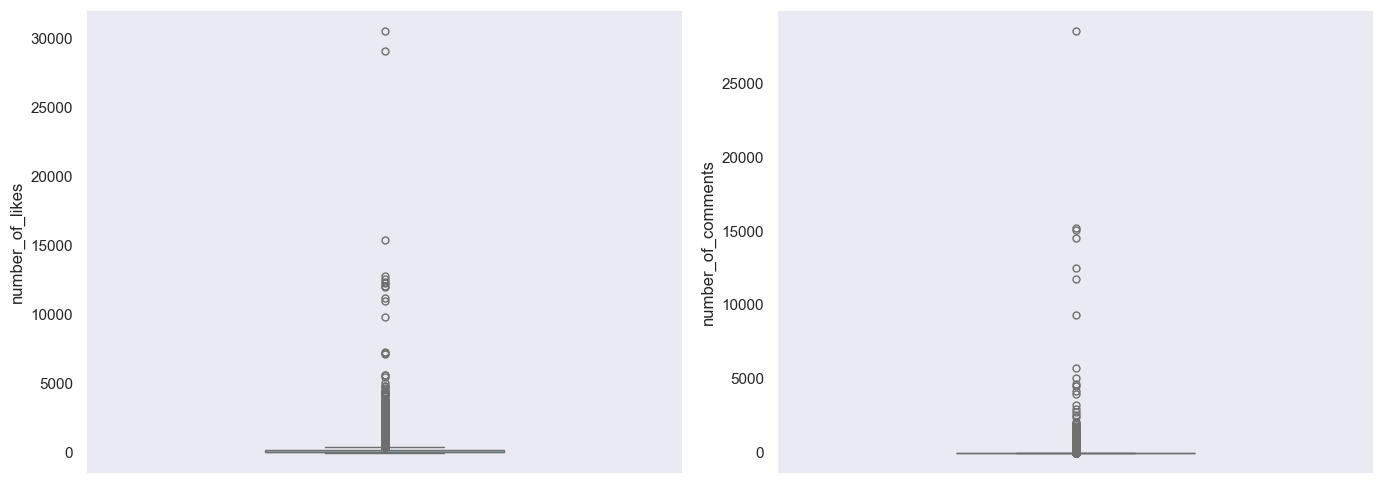

In [223]:
plot_boxplots(df=final_new_df, numerical_features=TARGET_FEATURES)

### Target metric balance across type of account
In the following subchapter **local** and **international** agencies data were explored to find outliers there

Code below shows that both of the groups still have many outliers:
- `international` - effects that were observed on the whole dataset remains the same 
- `local` - agencies have almost the same **mean** and **median**, but difference between max and 75-quantile is still **extremely different**

In [224]:
generate_account_summary_html(df=final_new_df, group_by_column=FIRST_GROUP_FEATURE)

,number_of_comments,number_of_likes
count,17573.000000,17573.000000
mean,22.297388,233.034542
std,347.598739,563.720323
min,0.000000,0.000000
25%,1.000000,61.000000
50%,3.000000,115.000000
75%,9.000000,236.000000
max,28517.000000,30546.000000
,number_of_comments,number_of_likes
count,3396.000000,3396.000000


Box plots supports the conclusions above (except for comments in `local` accounts). It seems like the good division since we'll erase only those outliers that are outliers for target group.

However, there is still a deeper level of data division that needs to be investigated to ensure that the outlier clean-up is correct - **account level**.

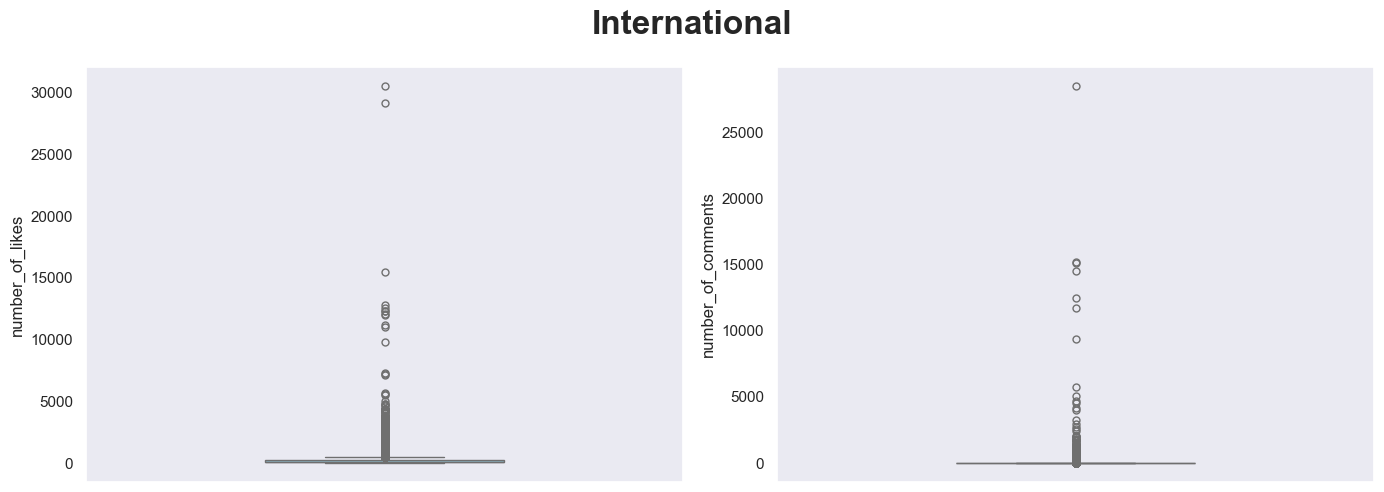

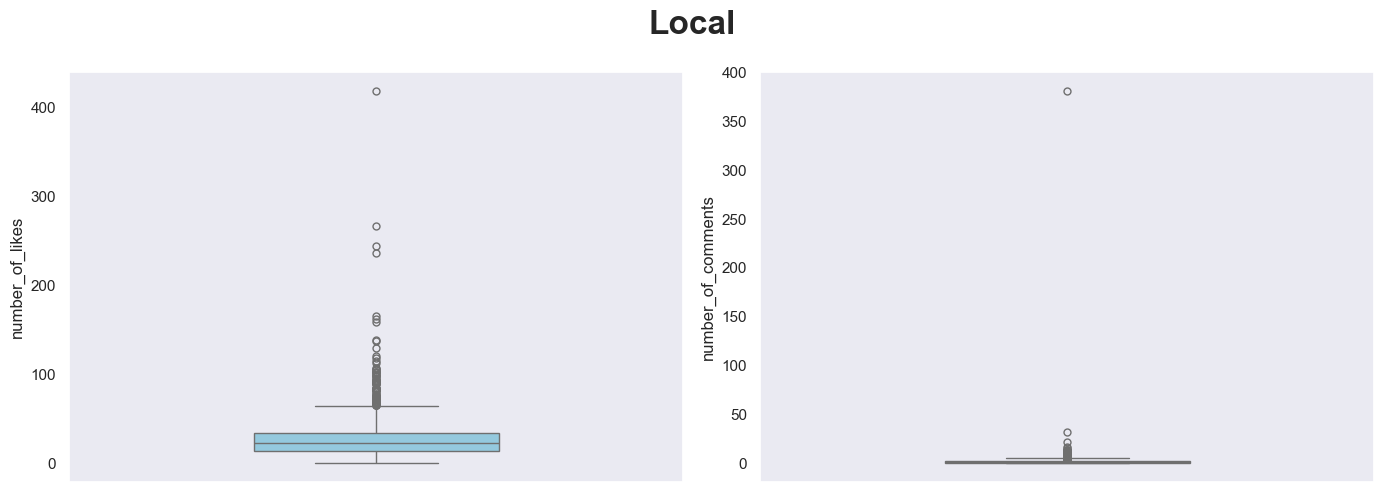

In [225]:
plot_boxplots(df=final_new_df, numerical_features=TARGET_FEATURES, split_feature=FIRST_GROUP_FEATURE)

To check is there any difference between accounts in one type, we decided to draw a plot below.

Main takeaways:
- `likes` in `international` - most part of outliers are produced by **3** accounts
- `comments` in `international` - most part of outliers are produced by **2** accounts
- `likes` in `local` - most part of outliers are related to one account
- `comments` in `local` - only one of accounts has outlier

In the end, the team decided to continue to dig into the partitioning 

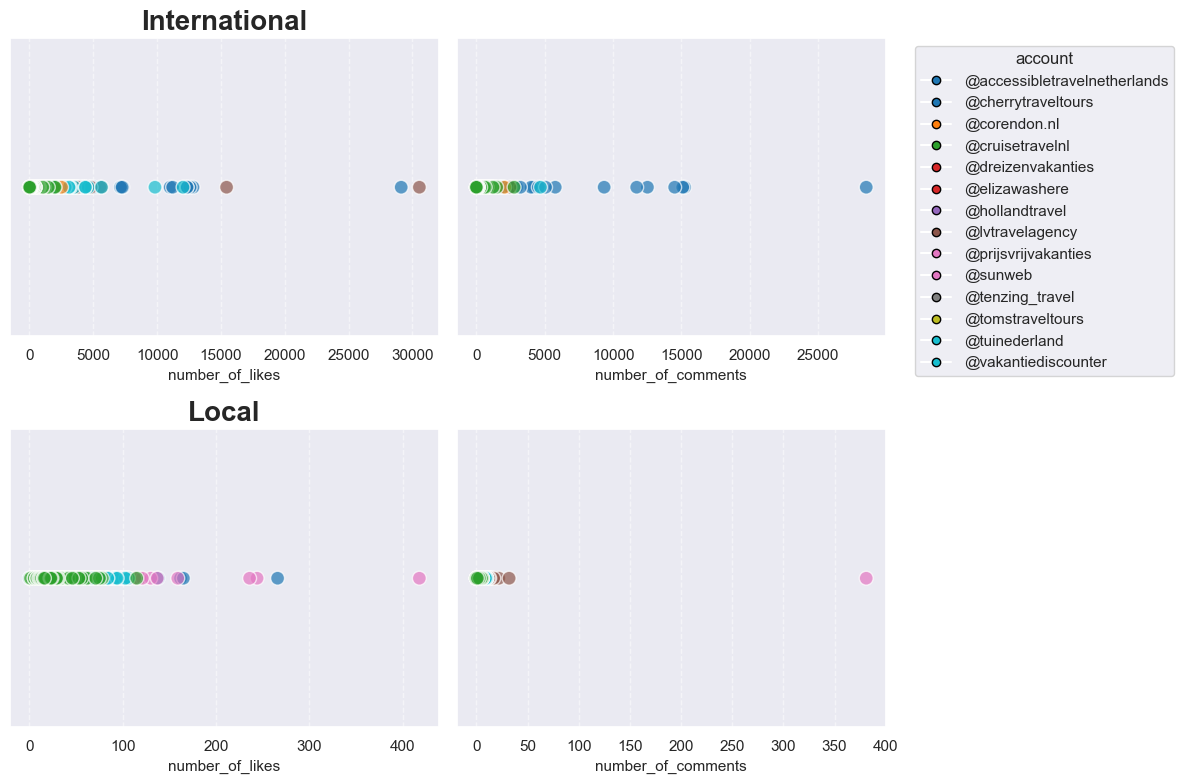

In [226]:
plot_points_colored_by_feature(df=final_new_df, split_column=FIRST_GROUP_FEATURE, position_columns=TARGET_FEATURES,
                               color_column=SECOND_GROUP_FEATURE)

### Target metrics balance across accounts
In this chapter we explored the outliers into the last level of partition: `account`

Final decision:
- use `account` to divide data for outlier removal 
- use **IQR** for outlier removal

The following specialities were mentioned during outlier analyses for different accounts:
- not all the accounts contains outliers (i.e. `@accessibletravelnetherlands,` `@cruisetravelnl` and even `@sunweb` have much less difference between 75-quantile and max value than @corendon)
- the same works for comparison between mean and median. Moreover, they can be insanely various across different acounts in one group (i.e. `@tuinederland` and `@sunweb`)
- hence, if we apply outlier removal directly to the `type` groups we can get into the case when values that wouldn't be recognized as outliers on `account` level have been deleted from dataset

In [227]:
generate_account_summary_html(df=final_new_df, group_by_column="account")

,number_of_comments,number_of_likes
count,204.000000,204.000000
mean,1.044118,23.686275
std,1.649904,14.839025
min,0.000000,0.000000
25%,0.000000,11.000000
50%,0.000000,21.000000
75%,2.000000,35.250000
max,9.000000,68.000000
,number_of_comments,number_of_likes
count,1027.000000,1027.000000


Boxplots supports the conclusions above. Thus, the team made a decision to use `account` level of splitting for **outliers removal**

Apart from that, the team decide to use **Inter-quantile range** method of outlier removal with the following justification: the distributions of the number of comments are heavily **right-skewed**, with **long tails** and a **high density** of points clustered near the lower end. Since the IQR method does not assume *normality*, it's more appropriate than `z-score–based techniques` for these kinds of distributions.

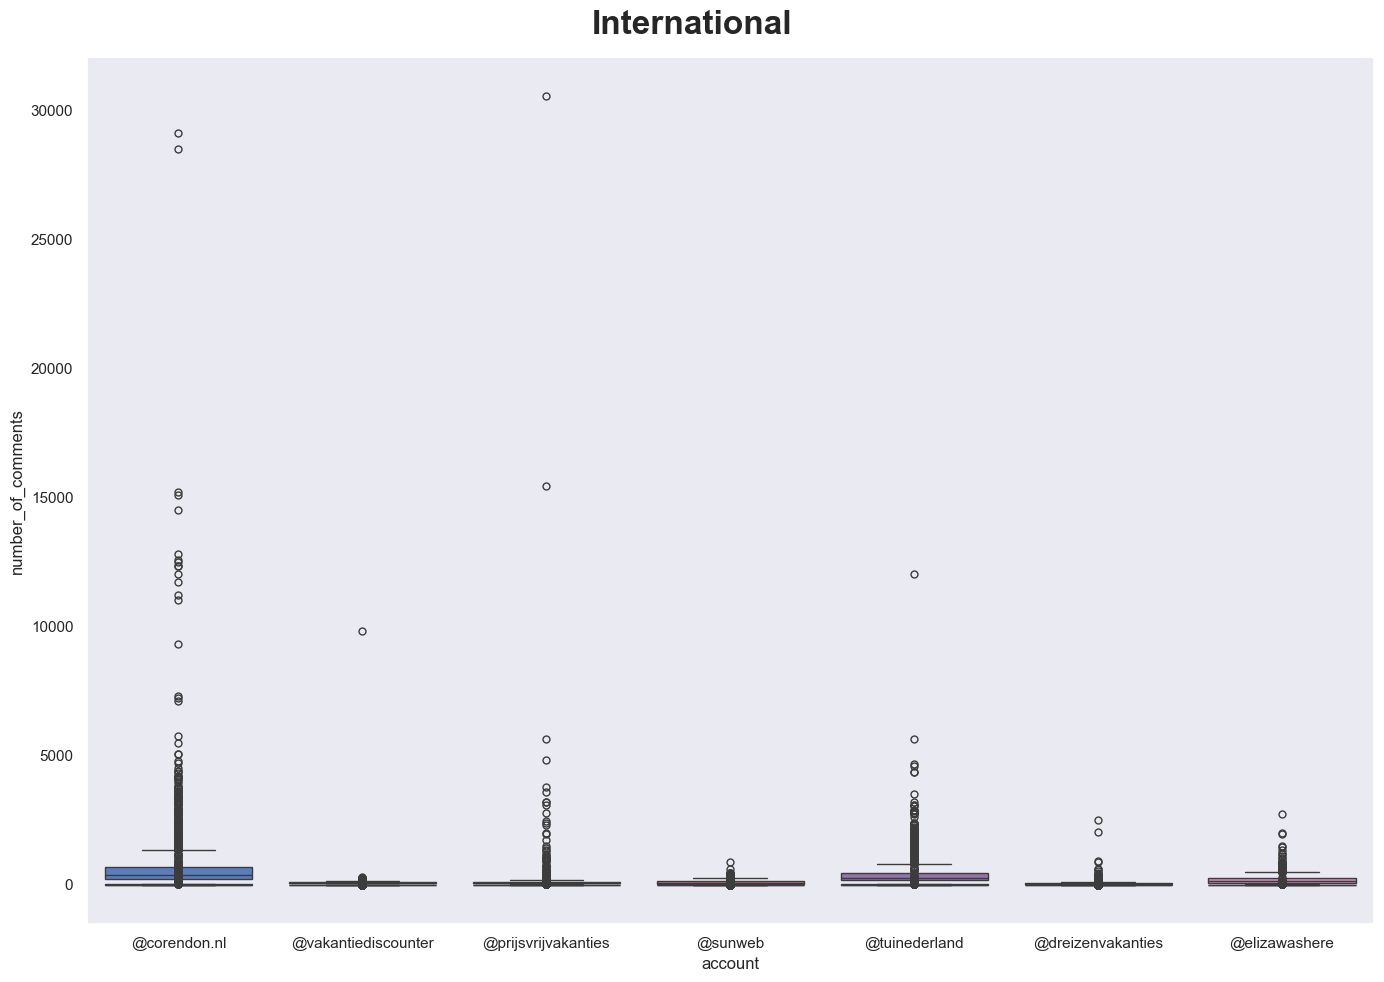

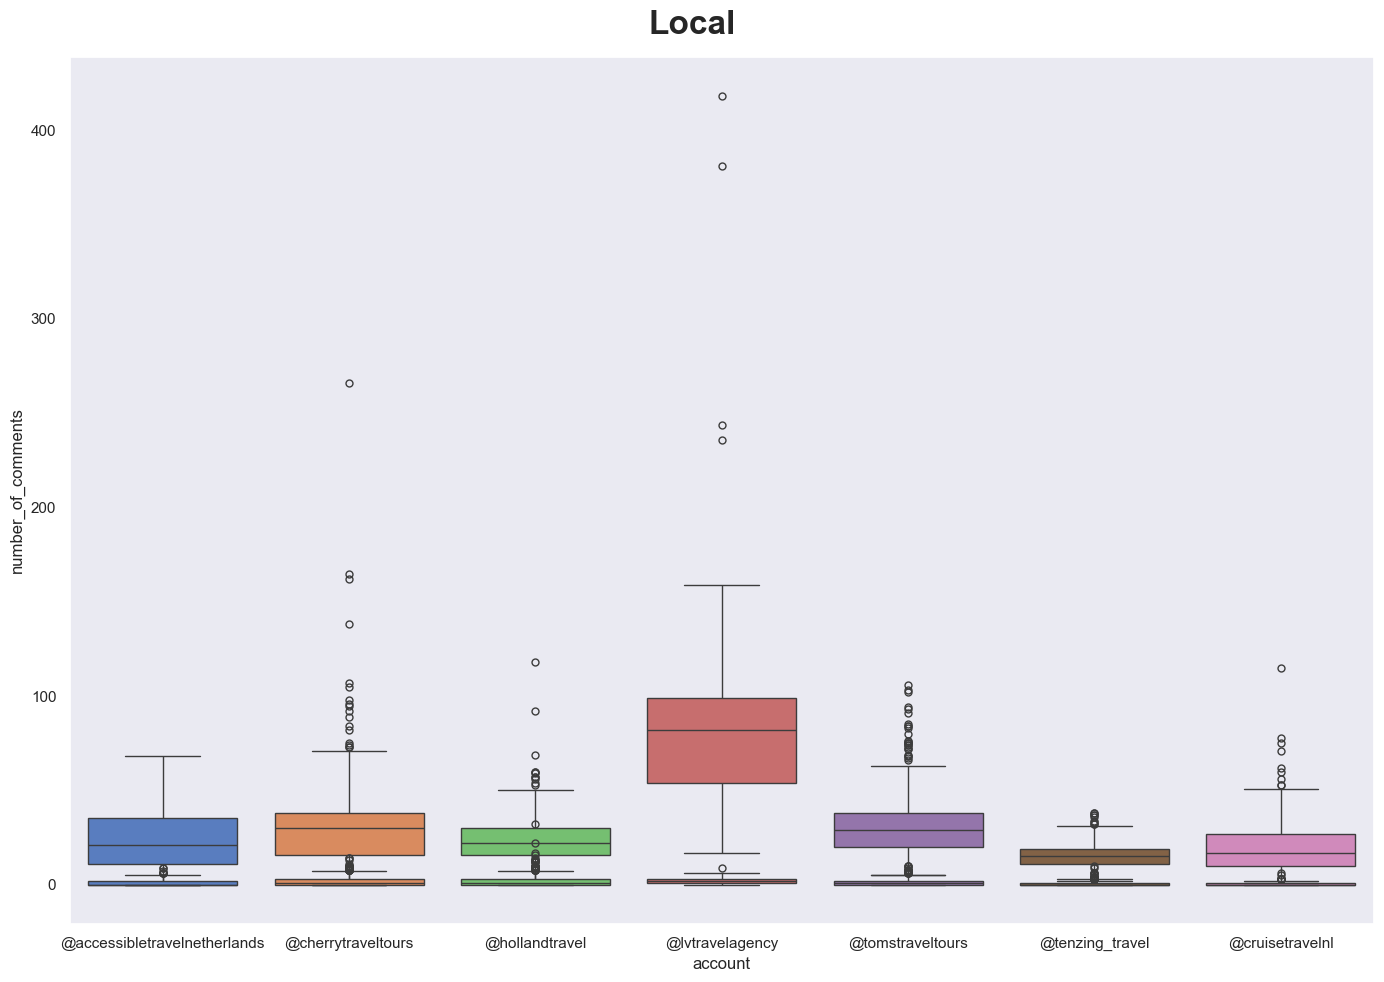

In [228]:
plot_boxplots(df=final_new_df, numerical_features=TARGET_FEATURES, split_feature=FIRST_GROUP_FEATURE,
              internal_split_feature=SECOND_GROUP_FEATURE)

### Outliers removal
Since we've concluded following:
- the most optimal strategy of outliers removal is removal **based on the `account`**
- the most optimal method is **IQR method**

The following code remove outliers for every account value

In [229]:
cleaned_parts = []

# Loop through all the accounts
for account in final_new_df['account'].unique():
    # Remove outliers
    current_brand_data = final_new_df[final_new_df['account'] == account]
    cleaned_data = remove_outliers_by_quantile(current_brand_data, TARGET_FEATURES)
    cleaned_parts.append(cleaned_data)

# Restore dataframe
final_cleaned_df = pd.concat(cleaned_parts, ignore_index=False)
final_cleaned_df

,number_of_comments,number_of_likes,account,type,is_collaboration,day_of_the_week,is_weekend,has_personal_words,is_above_avg_length,is_photo,is_peak
message_id,,,,,,,,,,,
18038388467208858,3,182,@corendon.nl,international,False,Monday,False,True,True,False,False
18039075278448488,0,92,@corendon.nl,international,False,Sunday,True,True,True,True,False
18085134403543445,1,131,@corendon.nl,international,False,Sunday,True,True,False,False,False
17842557165447487,0,164,@corendon.nl,international,False,Saturday,True,True,True,True,False
18046848881361680,5,249,@corendon.nl,international,False,Friday,False,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...
18080362180126910,1,17,@cruisetravelnl,local,False,Tuesday,False,False,False,True,False
17868232276456526,0,22,@cruisetravelnl,local,False,Friday,False,True,False,True,True
17847898231507730,2,24,@cruisetravelnl,local,False,Monday,False,True,False,True,True


As it's possible to see, the effect of outliers **has been neutralized**:
- mean differs from median no more than in **2 times**
- maximum value and 75-quantile has become closer to each other more than in **10 times**

In [230]:
final_cleaned_df.describe()

,number_of_comments,number_of_likes
count,18536.000000,18536.000000
mean,4.083243,138.080276
std,5.463134,163.360346
min,0.000000,0.000000
25%,1.000000,36.000000
50%,2.000000,80.000000
75%,5.000000,174.000000
max,41.000000,1358.000000


## Mean and balance check
In this chapter the following analysis conducted:
- visual comparison of means of target features between the groups divided by the **independent features** + their confidence intervals. Analysis provided both for `international` and `local`
- visual comparison amount of the values between the same groups 

Extract `international` and `local` datasets that will be used for the further statistical testing

In [231]:
international_df = final_cleaned_df[final_cleaned_df['type'] == 'international']
local_df = final_cleaned_df[final_cleaned_df['type'] == 'local']

international_df.size, local_df.size

(169092, 34804)

Here it's possible to mention that there is a huge difference in means between `local` and `international` agencies in the level of likes and comments (**target metrics**) with **small CI** (which most probably means the big size of the sample)

That strongly supports the idea that for this agencies it's necessary to develop different strategies, however, the difference is still necessary to prove by **statistical testing**

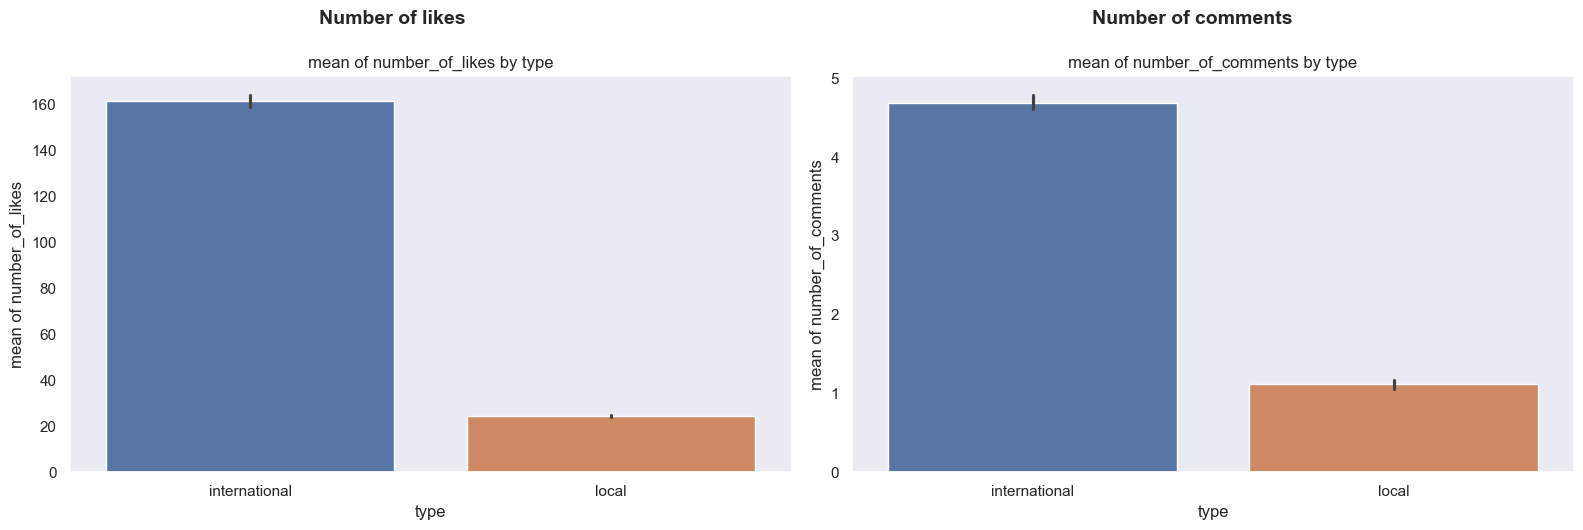

In [232]:
plot_grouped_feature_bars(df=final_cleaned_df, x_cols=[FIRST_GROUP_FEATURE], features=TARGET_FEATURES)

### International travel agencies

In the charts below means with confidence intervals (95%) are shown

Main specialities that were discovered:
- group of `is_peak` and `is_above_avg_length` (in comments) have big intersection in their CIs which potentially tend to difference of means of their population
- other divisions except `is_collaboration` have visual difference in means and not very wide CIs
- `is_collaboration` with the value `True` has enormous CI most probably because of the small sample size. That means that even if equality of means will be rejected this results remains not very accurate and may have deviations

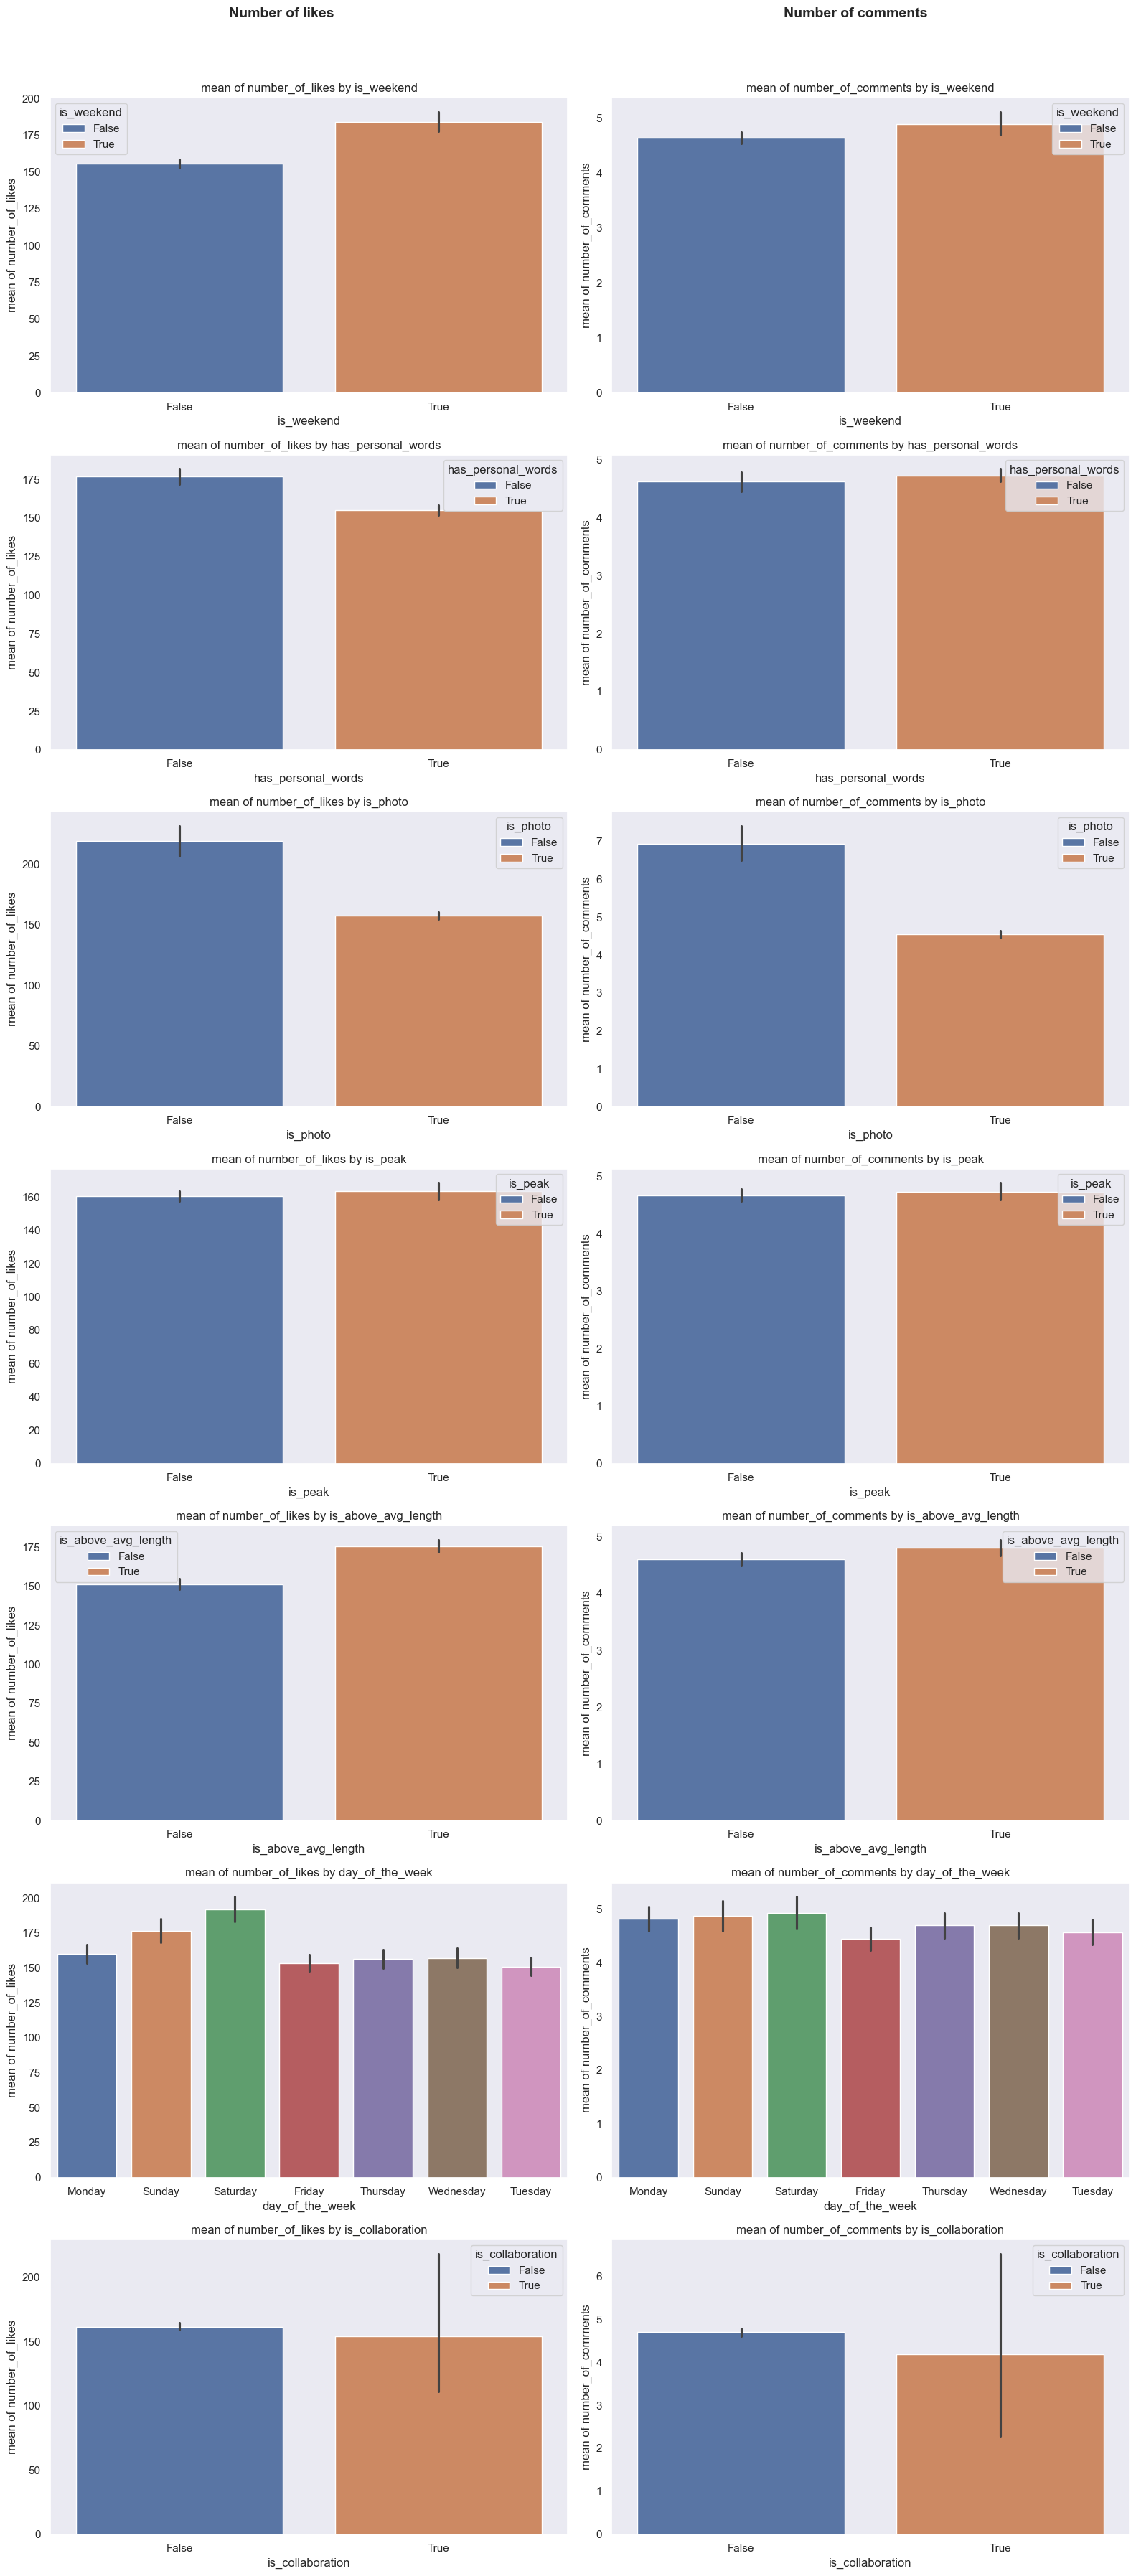

In [233]:
plot_grouped_feature_bars(df=international_df, x_cols=INDEPENDENT_FEATURES, features=TARGET_FEATURES)

Some of the bullet points above were proven by the charts with `count` estimator of every group:
- most part of the divisions are compatible to each other (the ratio of counts is less then 1 / 10) 
- there are exceptions with `is_photo` and especially with `is_collaboration`, because one of their splits is much smaller than another. That supports the idea that even if we'll reject the hypothesis of mean's equality we have to be cautious and wary with results.

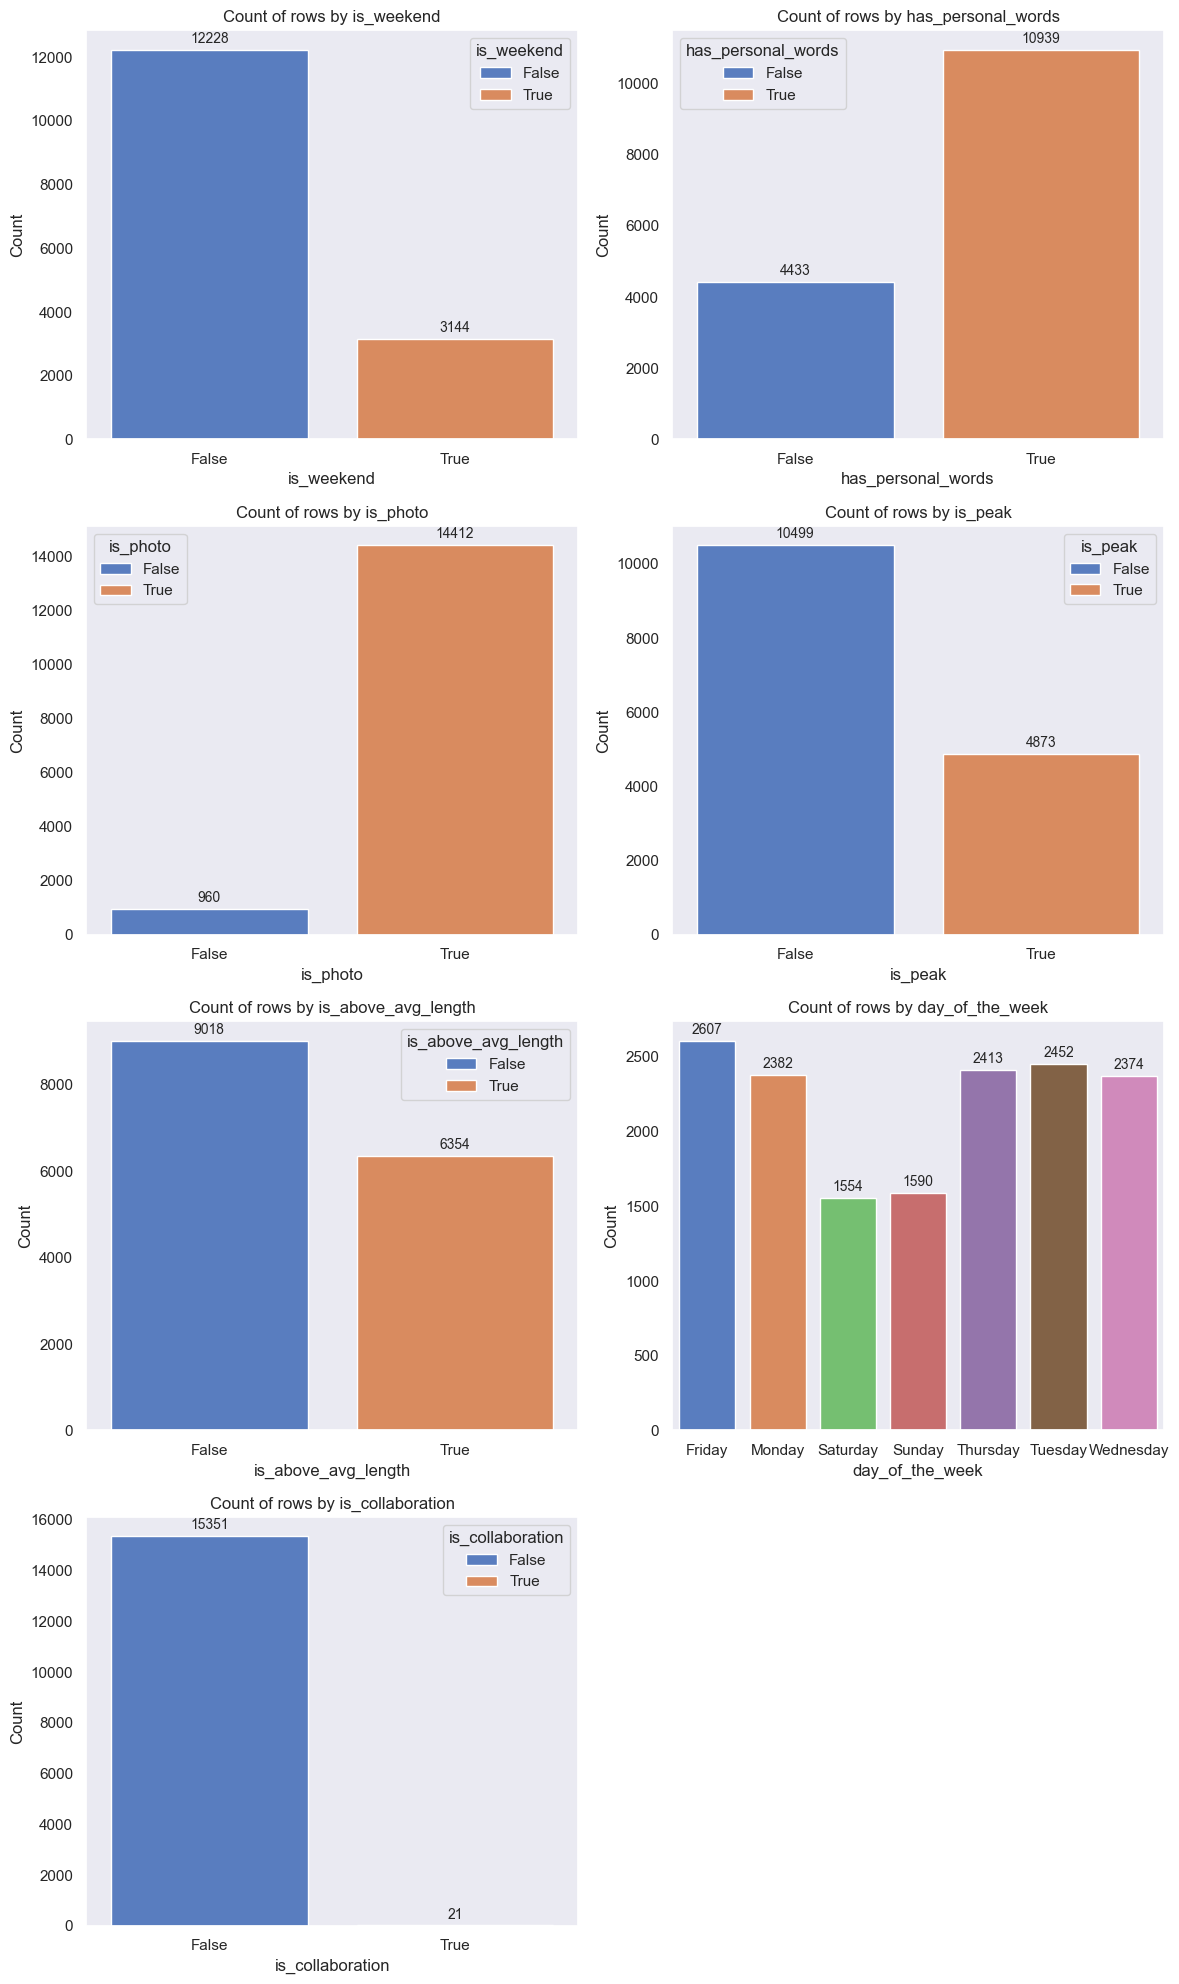

In [234]:
plot_category_counts(df=international_df, x_cols=INDEPENDENT_FEATURES)

### Local travel agencies

Results for **local** agencies are mostly the same as for **international** agencies:
- splits of `is_photo` and `is_collaboration` are still imbalanced so it's necessary to be cautious about the results with them
- the rest of splits are more or less balanced  

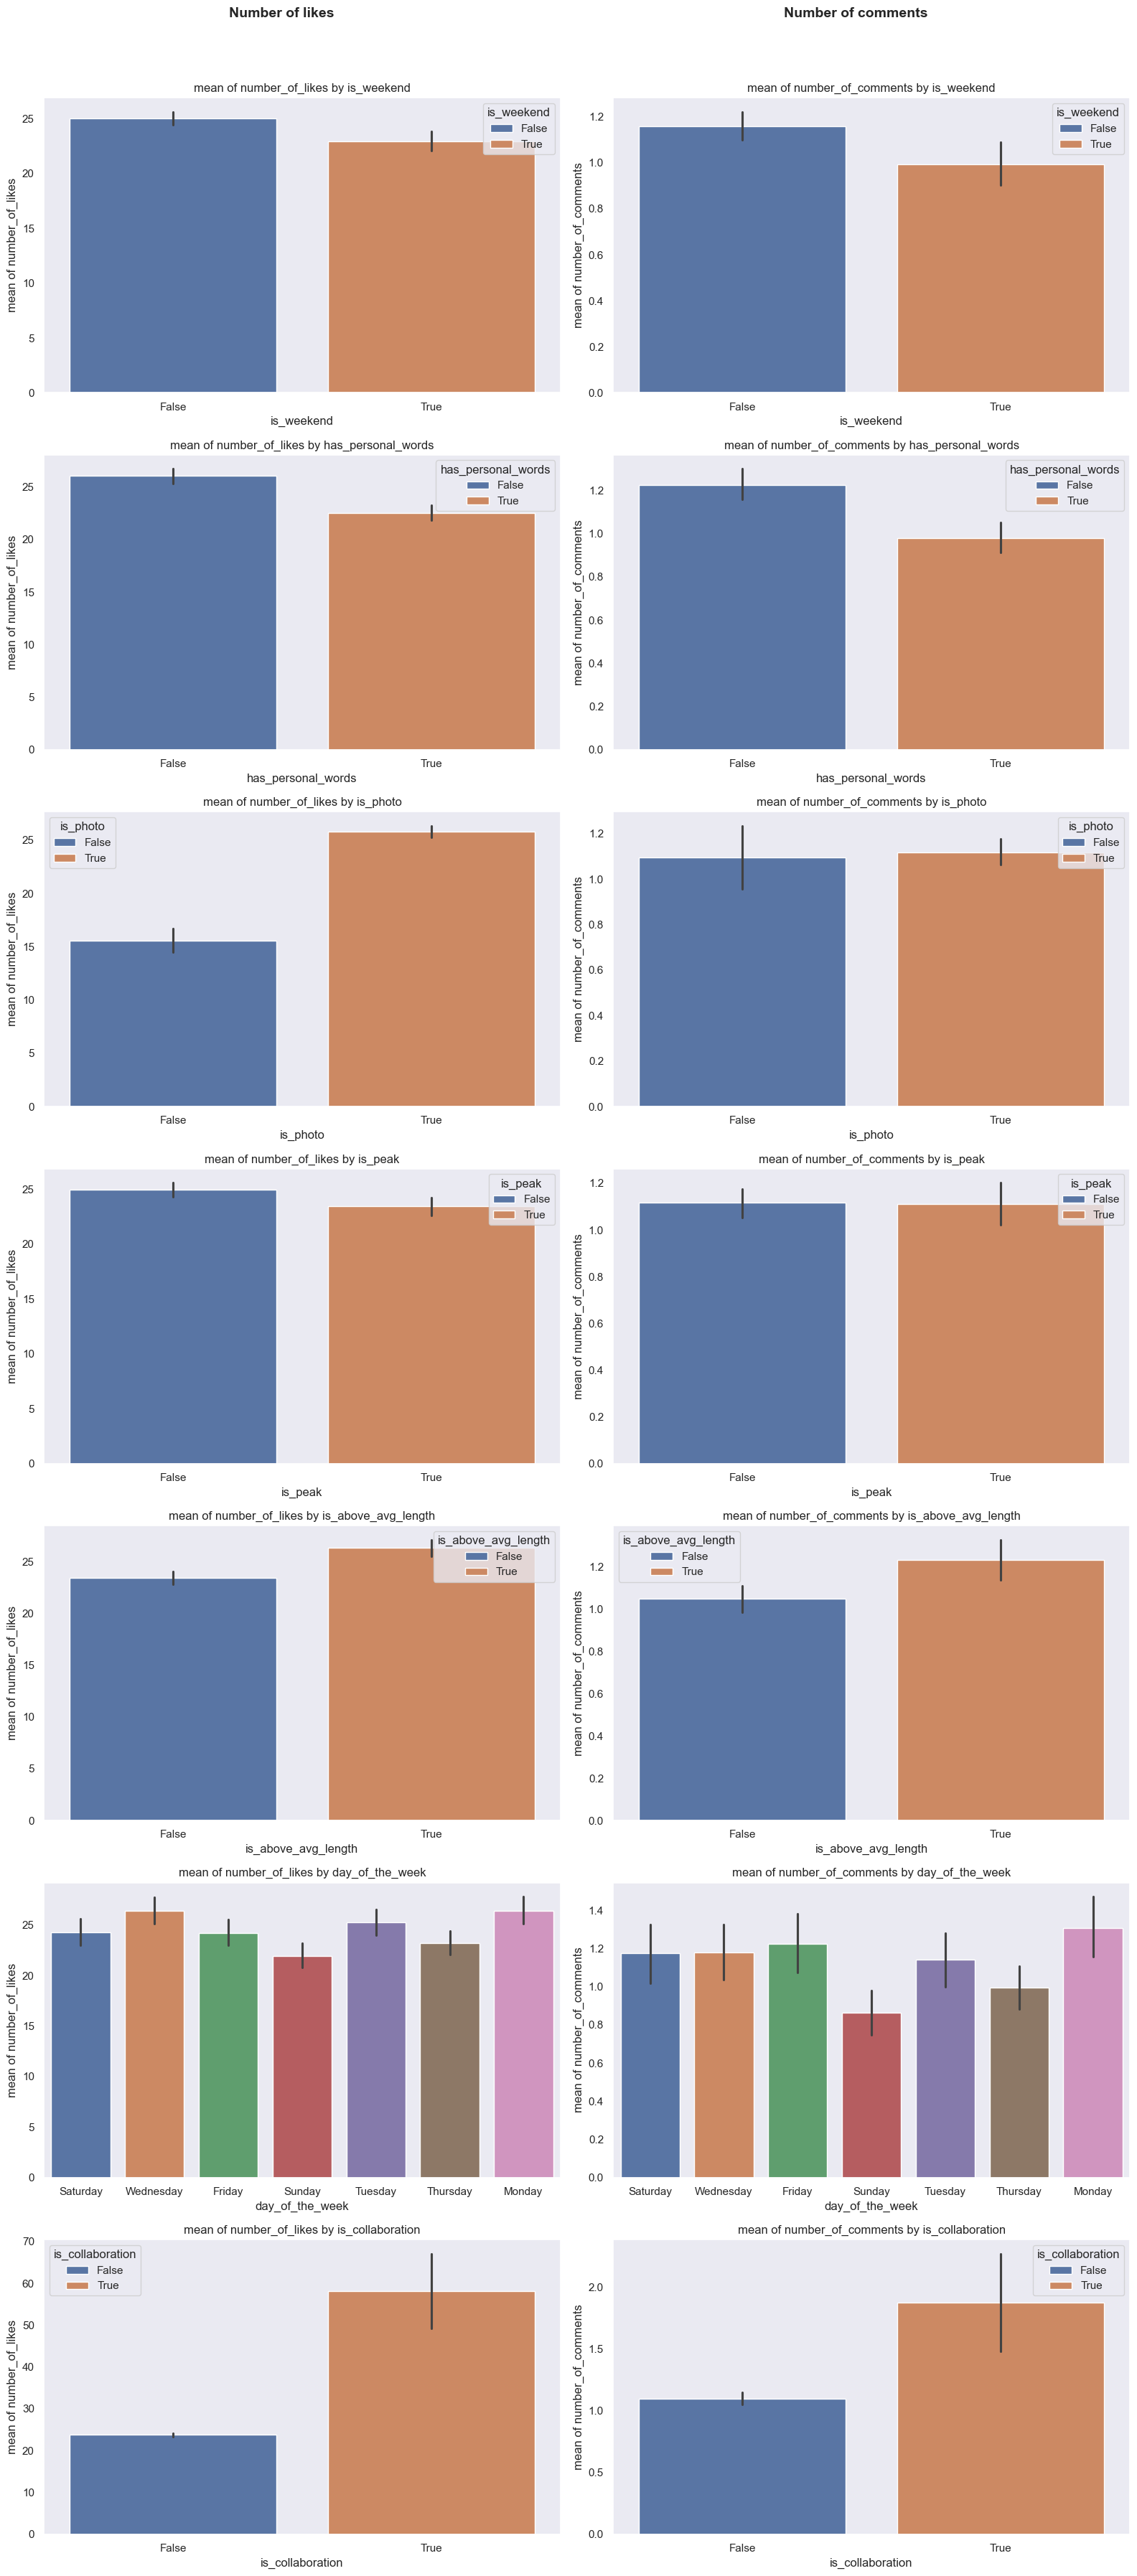

In [235]:
plot_grouped_feature_bars(df=local_df, x_cols=INDEPENDENT_FEATURES, features=TARGET_FEATURES)

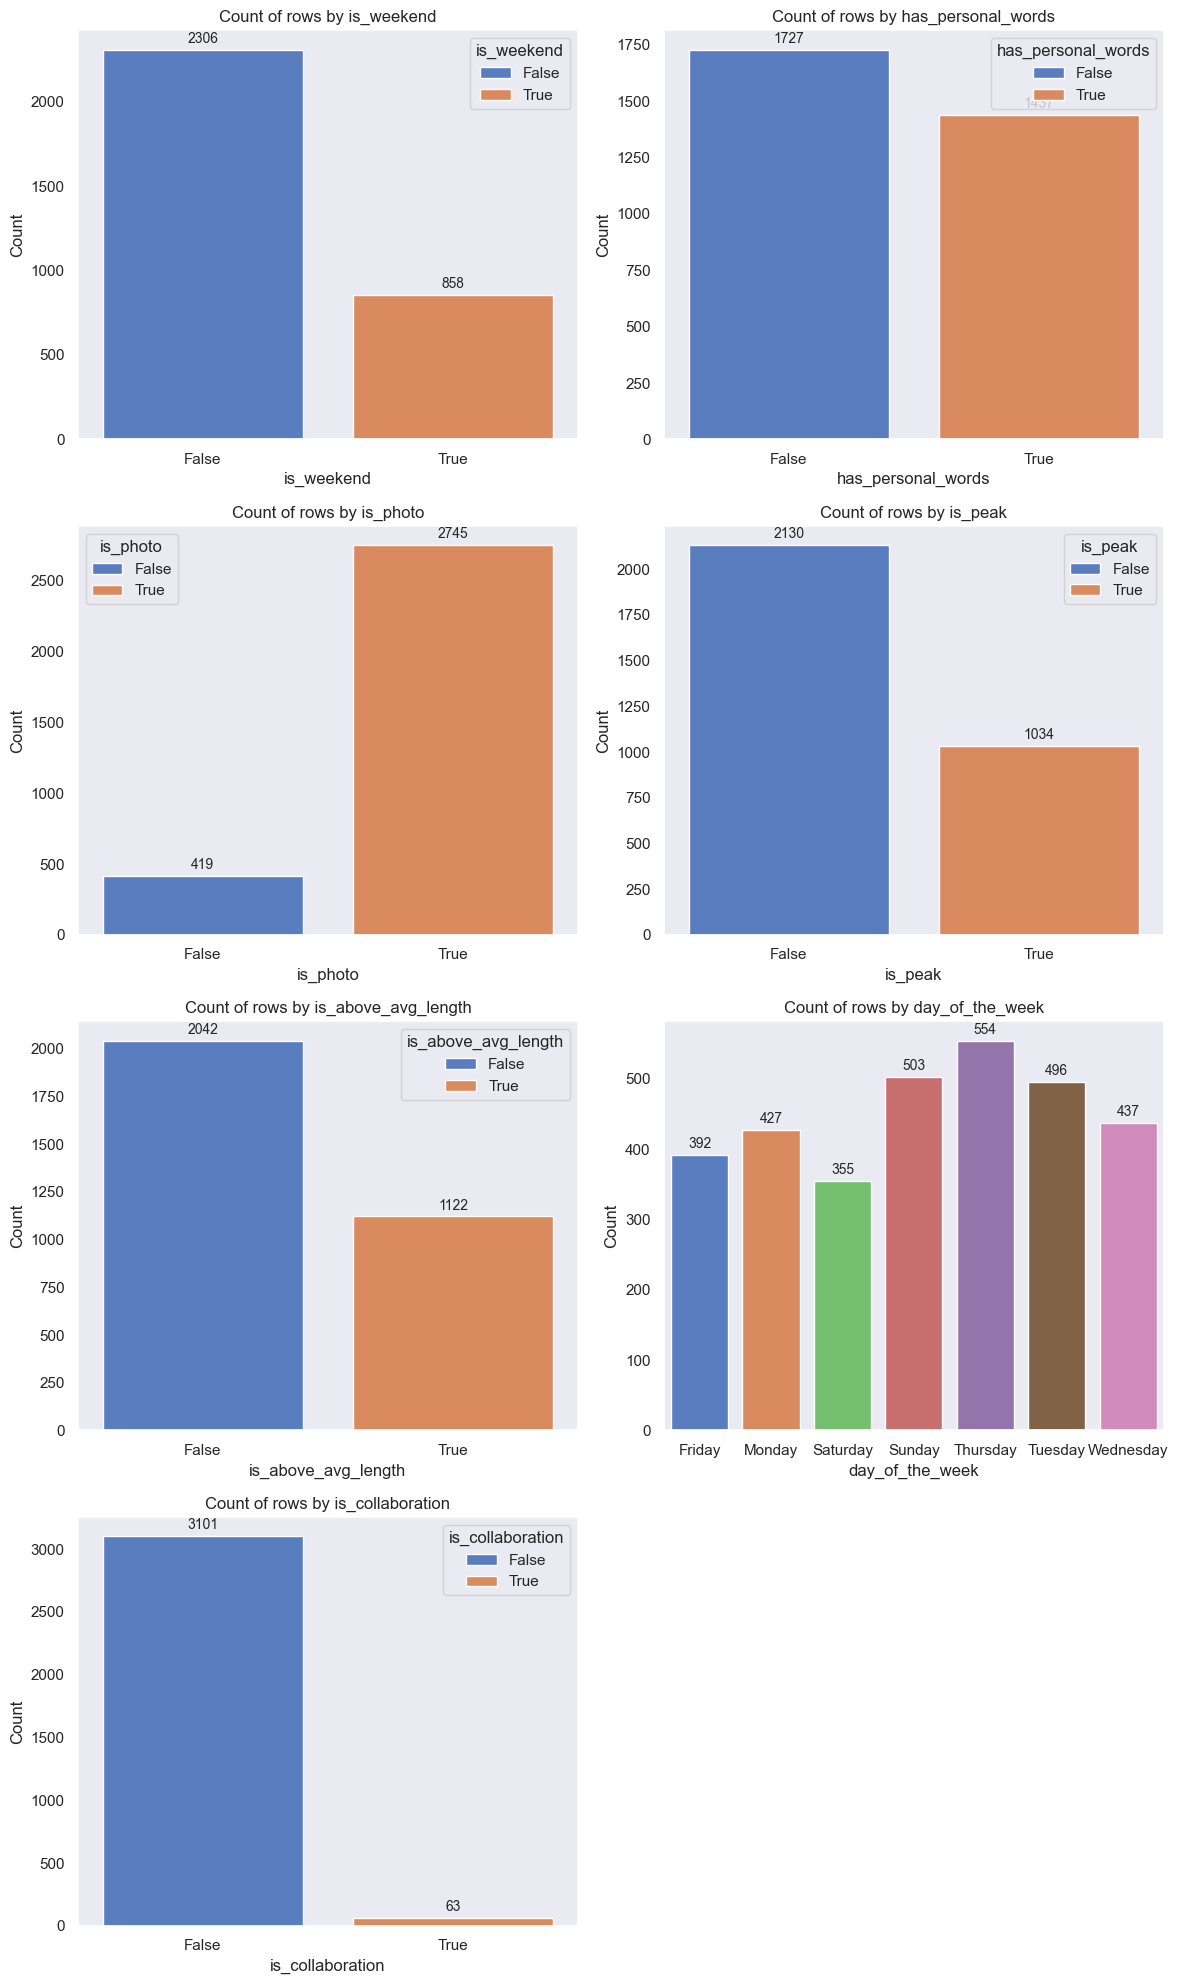

In [236]:
plot_category_counts(df=local_df, x_cols=INDEPENDENT_FEATURES)

In the end, all the features that were developed during the **literature review** have potentially different means of **target features** in the samples (despite the fact some of the CIs are crossing each other). 

Based on that the hypothesises below were formulated for the further statistical testing

# Statistical testing of number of likes

In this chapter we conduct statistical testing on the hypothesises of mean's equality between splits on predefined features in `number_of_likes`

The following instruments were used:
- **shapiro** or **normaltest** for normality check
- **levene** test for check for homogeneity of variances  
- **t-test** or **Mann U Whitney test** for two sample means comparison  
- **ANOVA** or **Kruskal-Wallis test** for several sample means comparison

Below significance level for all the tests

In [237]:
SIGNIFICANCE_LEVEL = 0.05

## International vs local in likes

In [238]:
all_likes = extract_target_feature(df=final_cleaned_df, split_feature="type", target_feature="number_of_likes")
all_likes

{'international': array([182,  92, 131, ...,  15,  13,  10]),
 'local': array([ 9, 25,  5, ..., 24, 23, 16])}

### Visualization of distributions

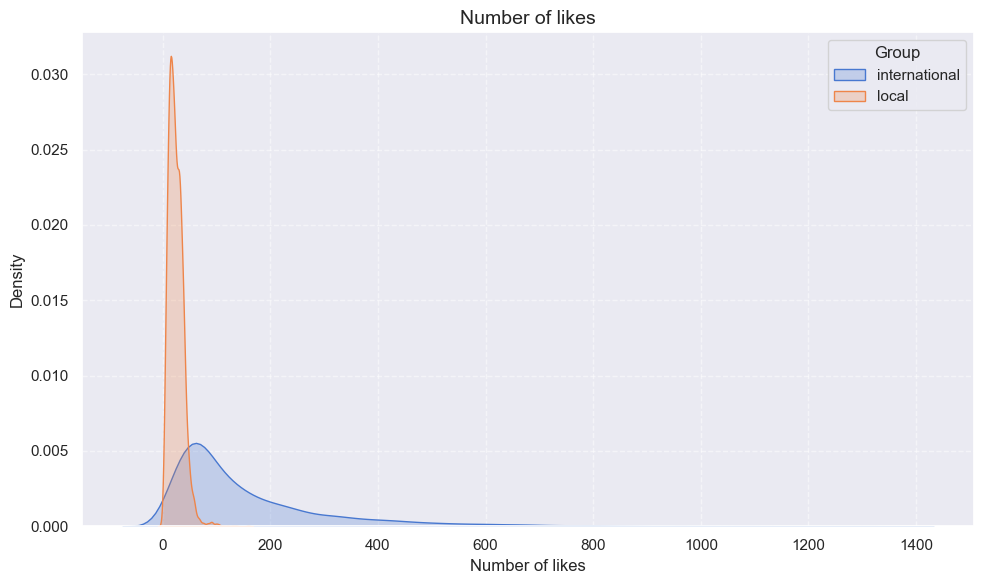

In [239]:
plot_distributions(data=all_likes, title="Number of likes", xlabel="Number of likes", ylabel="Density")

### Statistical test 

In [240]:
local_likes, international_likes = all_likes['local'], all_likes['international']
len(local_likes), len(international_likes)

(3164, 15372)

In [241]:
likes_test = TwoSampleStatisticalTests(first_dataset=international_likes, second_dataset=local_likes,
                                       significance_level=SIGNIFICANCE_LEVEL)
likes_test.test_two_numerical_samples(is_one_tailed=True)

The result of the p-value when checking the normality for the first dataset: 0.0
The result of the p-value when checking the normality for the second dataset: 1.51943222421626e-41
The result of the p-value when checking the variance uniform: 2.568645329025122e-285
Mann-Whitney was chosen
Final p-value: 0.0
H0 has been rejected, Ha has been accepted


### Key takeaway

## Peak vs non-peak in likes (international)

In [242]:
peak_likes_arr = extract_target_feature(df=international_df, split_feature="is_peak", target_feature="number_of_likes")
peak_likes_arr

{False: array([182,  92, 131, ...,  18,  11,  10]),
 True: array([ 278, 1294,  862, ...,   15,   15,   13])}

### Visualization of distributions

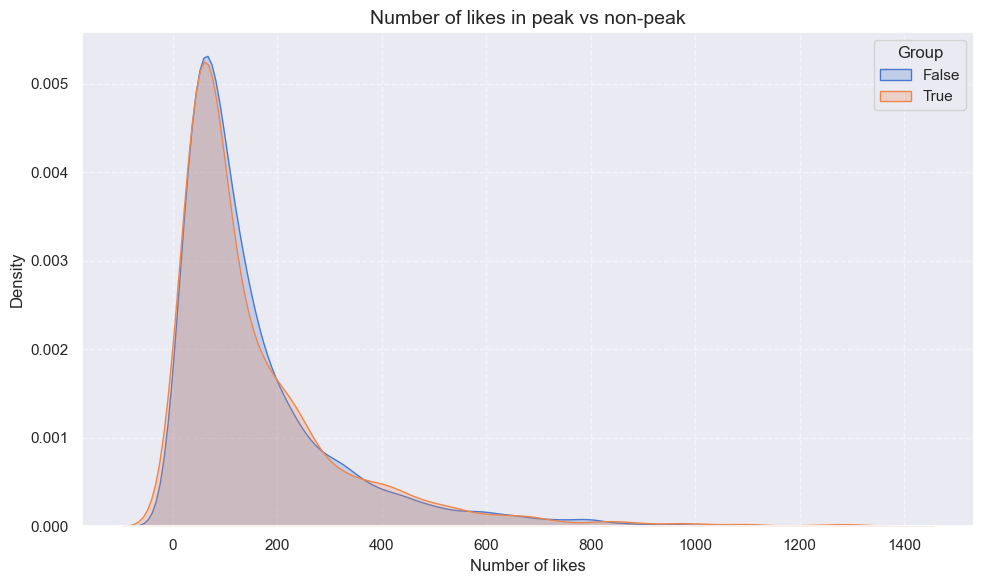

In [243]:
plot_distributions(data=peak_likes_arr, title="Number of likes in peak vs non-peak", xlabel="Number of likes",
                   ylabel="Density")

### Statistical test

In [244]:
peak_likes, non_peak_likes = peak_likes_arr[True], peak_likes_arr[False]
len(peak_likes), len(non_peak_likes)

(4873, 10499)

In [245]:
peak_likes_test = TwoSampleStatisticalTests(first_dataset=peak_likes, second_dataset=non_peak_likes,
                                            significance_level=SIGNIFICANCE_LEVEL)
peak_likes_test.test_two_numerical_samples(is_one_tailed=True)

The result of the p-value when checking the normality for the first dataset: 2.3356400540656153e-67
The result of the p-value when checking the normality for the second dataset: 0.0
The result of the p-value when checking the variance uniform: 0.02108946858853584
Mann-Whitney was chosen
Final p-value: 0.928966595536894
H0 was not rejected


### Key takeaway

## Collaboration presence in likes (international)

In [246]:
collaboration_likes_arr = extract_target_feature(df=international_df, split_feature="is_collaboration",
                                                 target_feature="number_of_likes")
collaboration_likes_arr

{False: array([182,  92, 131, ...,  15,  13,  10]),
 True: array([169, 200, 102, 121, 119,  63,  87,  76, 147,  72, 121,  94, 149,
        145, 714, 152, 180, 200, 129, 184,   8])}

### Visualization of distributions

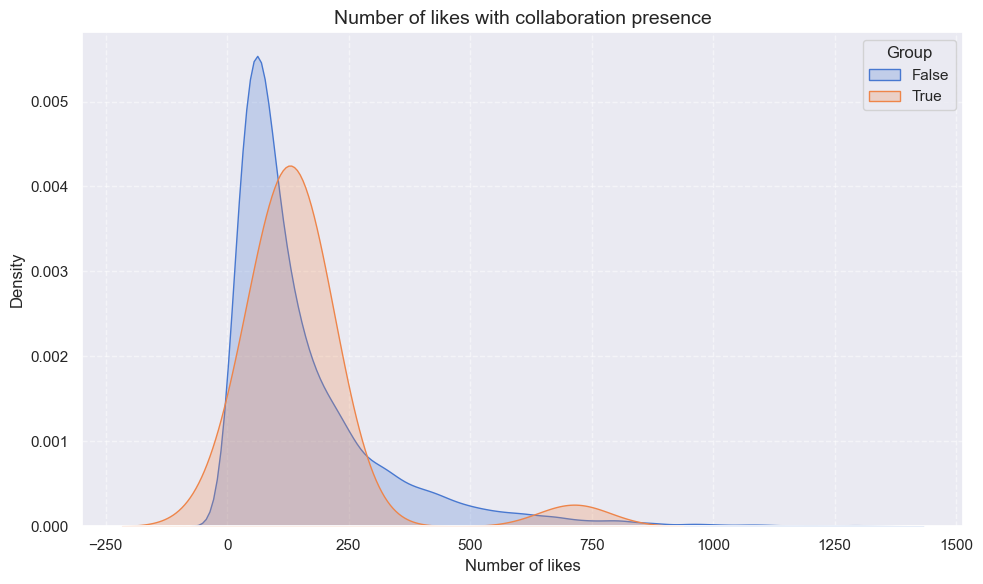

In [247]:
plot_distributions(data=collaboration_likes_arr, title="Number of likes with collaboration presence",
                   xlabel="Number of likes", ylabel="Density")

### Statistical testing

In [248]:
collab_likes, non_collab_likes = collaboration_likes_arr[True], collaboration_likes_arr[False]
len(collab_likes), len(non_collab_likes)

(21, 15351)

In [249]:
collab_likes_test = TwoSampleStatisticalTests(first_dataset=collab_likes, second_dataset=non_collab_likes,
                                              significance_level=SIGNIFICANCE_LEVEL)
collab_likes_test.test_two_numerical_samples(is_one_tailed=True)

The result of the p-value when checking the normality for the first dataset: 1.0343582134380034e-06
The result of the p-value when checking the normality for the second dataset: 0.0
The result of the p-value when checking the variance uniform: 0.2042003122882241
Mann-Whitney was chosen
Final p-value: 0.14650776954274602
H0 was not rejected


### Key takeaway

## Weekend vs weekday in likes (international)

In [250]:
weekend_likes_arr = extract_target_feature(df=international_df, split_feature="is_weekend",
                                           target_feature="number_of_likes")
weekend_likes_arr

{False: array([182, 249, 809, ...,  15,  13,  10]),
 True: array([ 92, 131, 164, ...,  12,  20,  39])}

### Visualization of distributions

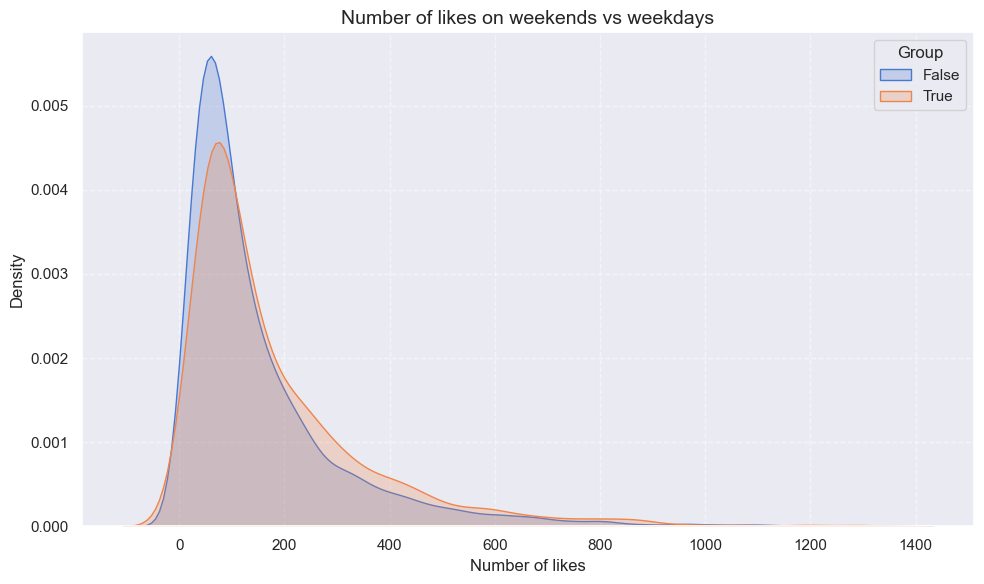

In [251]:
plot_distributions(data=weekend_likes_arr, title="Number of likes on weekends vs weekdays", xlabel="Number of likes",
                   ylabel="Density")

### Statistical test

In [252]:
weekend_likes, weekday_likes = weekend_likes_arr[True], weekend_likes_arr[False]
len(weekend_likes), len(weekday_likes)

(3144, 12228)

In [253]:
weekend_likes_test = TwoSampleStatisticalTests(first_dataset=weekend_likes, second_dataset=weekday_likes,
                                               significance_level=SIGNIFICANCE_LEVEL)
weekend_likes_test.test_two_numerical_samples(is_one_tailed=True)

The result of the p-value when checking the normality for the first dataset: 5.839423101563417e-55
The result of the p-value when checking the normality for the second dataset: 0.0
The result of the p-value when checking the variance uniform: 8.901635105365403e-08
Mann-Whitney was chosen
Final p-value: 3.1276844565375896e-27
H0 has been rejected, Ha has been accepted


### Key takeaway

## Content type in likes (international)

In [254]:
content_type_likes_arr = extract_target_feature(df=international_df, split_feature="is_photo",
                                                target_feature="number_of_likes")
content_type_likes_arr

{False: array([ 182,  131,  132,  231,  192,  107,  365,  178,  100,  361,  167,
         177,  233,  297,  333,  340,  467,  441,  224,  226,  232,  207,
         744,  228,  191,  183,  432,  164,  241,  364,  160,  376, 1294,
         613,  660,  263,  382,  189,  258,  553,  313,  267,  531,  383,
         304,  270,  435,  181,  303,  486,  604,  241,  169,  156,  194,
         216,  210,  531,  348,  233,  496,  305,  423,  256,  177,  195,
         186,  149,  220,  280,  310,  389,  221,  551,  399,  556,  397,
         403,  597,  184,  208,  457,  408,  315,  299,  160,  227,  302,
         337,  346, 1096,  392,  528,  549,  941,  481,  327,  657,  822,
         157,  553,  635,  172,  304, 1004,  209,  647,  274,  325,  291,
         247,  684,  675,  249,  279,  339,  237,  255,  191,  379,  293,
         502,  263,  468,  270,  272,  414,  272,  255,  374,  515,  337,
         363,  232,  299,  462,  253,  865,  563,  291,  688,  300,  422,
         674,  243,  369,  245,

### Visualization of distributions

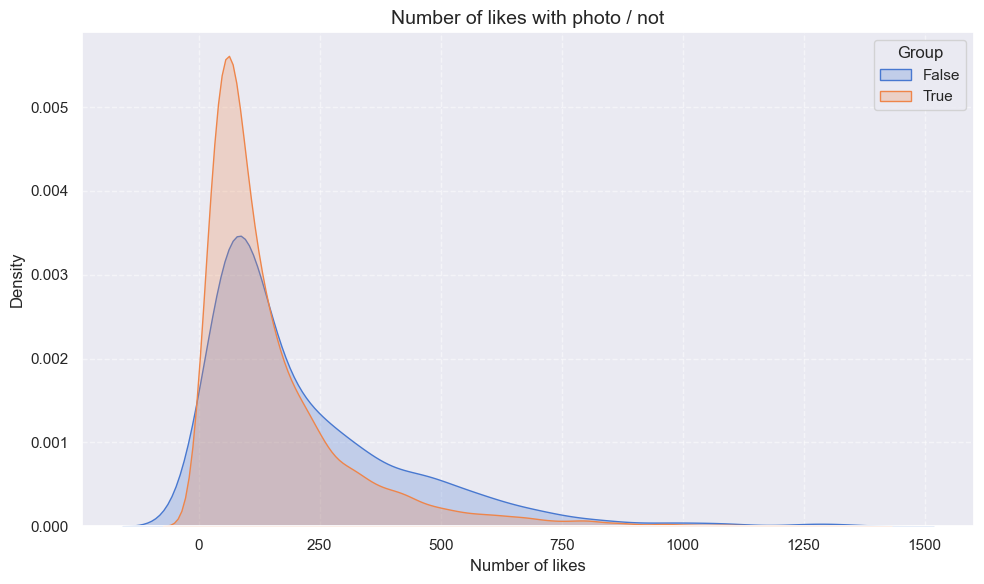

In [255]:
plot_distributions(data=content_type_likes_arr, title="Number of likes with photo / not", xlabel="Number of likes",
                   ylabel="Density")

### Statistical test

In [256]:
photo_likes, video_likes = content_type_likes_arr[True], content_type_likes_arr[False]
len(photo_likes), len(video_likes)

(14412, 960)

In [257]:
reel_likes_test = TwoSampleStatisticalTests(first_dataset=video_likes, second_dataset=photo_likes,
                                            significance_level=SIGNIFICANCE_LEVEL)
reel_likes_test.test_two_numerical_samples(is_one_tailed=True)

The result of the p-value when checking the normality for the first dataset: 1.0560124447182964e-32
The result of the p-value when checking the normality for the second dataset: 0.0
The result of the p-value when checking the variance uniform: 1.237526294826769e-18
Mann-Whitney was chosen
Final p-value: 7.820728452628987e-25
H0 has been rejected, Ha has been accepted


### Key takeaway

## Personal words in likes (international)

In [258]:
personal_words_likes_arr = extract_target_feature(df=international_df, split_feature="has_personal_words",
                                                  target_feature="number_of_likes")
personal_words_likes_arr

{True: array([182,  92, 131, ...,  15,  13,  10]),
 False: array([132, 231, 107, ...,  21,  19,  14])}

### Visualization of distributions

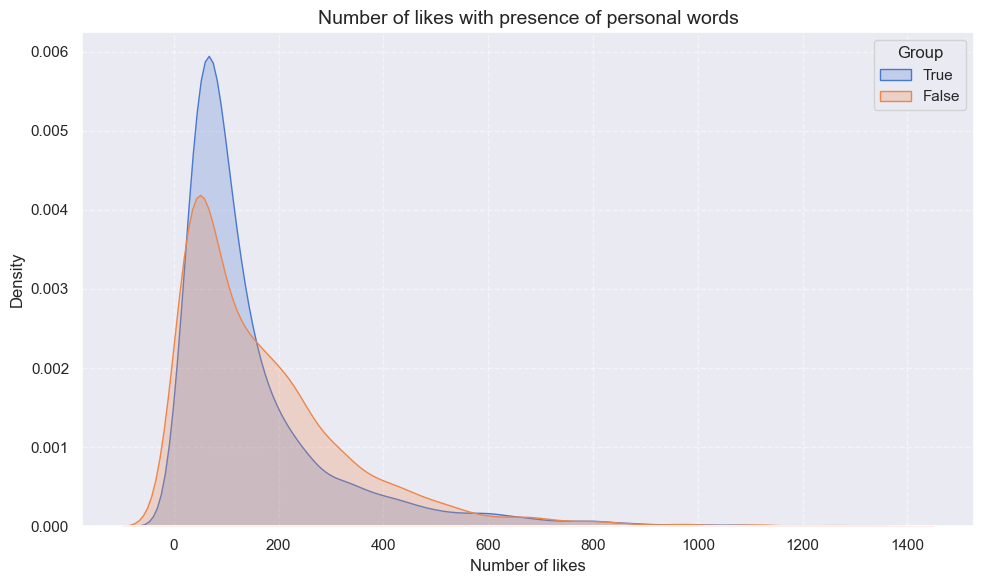

In [259]:
plot_distributions(data=personal_words_likes_arr, title="Number of likes with presence of personal words",
                   xlabel="Number of likes", ylabel="Density")

### Statistical test

In [260]:
personal_words_likes, non_personal_words_likes = personal_words_likes_arr[True], personal_words_likes_arr[False]
len(personal_words_likes), len(non_personal_words_likes)

(10939, 4433)

In [261]:
personal_likes_test = TwoSampleStatisticalTests(first_dataset=personal_words_likes,
                                                second_dataset=non_personal_words_likes,
                                                significance_level=SIGNIFICANCE_LEVEL)
personal_likes_test.test_two_numerical_samples(is_one_tailed=True)

The result of the p-value when checking the normality for the first dataset: 0.0
The result of the p-value when checking the normality for the second dataset: 3.379377524315516e-59
The result of the p-value when checking the variance uniform: 7.626438278366973e-18
Mann-Whitney was chosen
Final p-value: 0.9999999997664465
H0 was not rejected


### Key takeaway

## Length of the posts in likes (international)

In [262]:
length_post_likes_arr = extract_target_feature(df=international_df, split_feature="is_above_avg_length",
                                                  target_feature="number_of_likes")
length_post_likes_arr

{True: array([182,  92, 164, ...,  16,  16,  18]),
 False: array([131, 809, 132, ...,  15,  13,  10])}

### Visualization of distributions

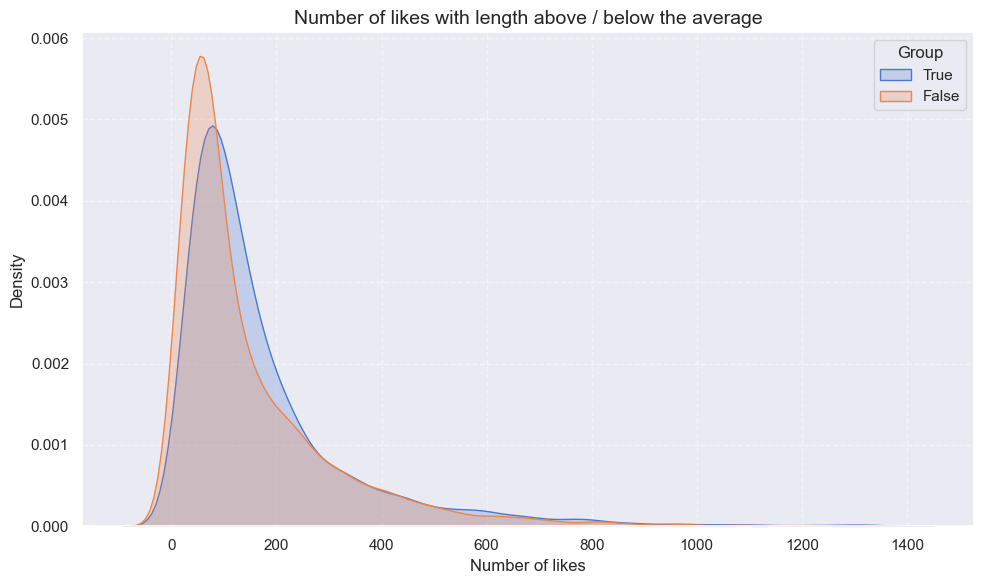

In [263]:
plot_distributions(data=length_post_likes_arr, title="Number of likes with length above / below the average",
                   xlabel="Number of likes", ylabel="Density")

### Statistical test

In [264]:
above_avg_length_likes, below_avg_length_likes = length_post_likes_arr[True], length_post_likes_arr[False]
len(above_avg_length_likes), len(below_avg_length_likes)

(6354, 9018)

In [265]:
length_likes_test = TwoSampleStatisticalTests(first_dataset=above_avg_length_likes,
                                                second_dataset=below_avg_length_likes,
                                                significance_level=SIGNIFICANCE_LEVEL)
length_likes_test.test_two_numerical_samples(is_one_tailed=True)

The result of the p-value when checking the normality for the first dataset: 0.0
The result of the p-value when checking the normality for the second dataset: 0.0
The result of the p-value when checking the variance uniform: 0.03946243579431918
Mann-Whitney was chosen
Final p-value: 1.3678930016508193e-52
H0 has been rejected, Ha has been accepted


### Key takeaway

## Day of the week in likes (international)

In [266]:
day_of_the_week_likes_arr = extract_target_feature(df=international_df, split_feature="day_of_the_week",
                                                  target_feature="number_of_likes")
day_of_the_week_likes_arr

{'Monday': array([182, 231, 118, ...,  15,  26,  15]),
 'Sunday': array([ 92, 131, 171, ...,  13,  12,  20]),
 'Saturday': array([164, 192, 107, ...,  37,  19,  39]),
 'Friday': array([249, 365, 178, ...,  11,  21,  14]),
 'Thursday': array([ 809, 1016,  233, ...,   19,   25,   33]),
 'Wednesday': array([132, 100, 182, ...,  81,  18,  15]),
 'Tuesday': array([361, 441, 297, ...,  15,  13,  10])}

### Visualization of distributions

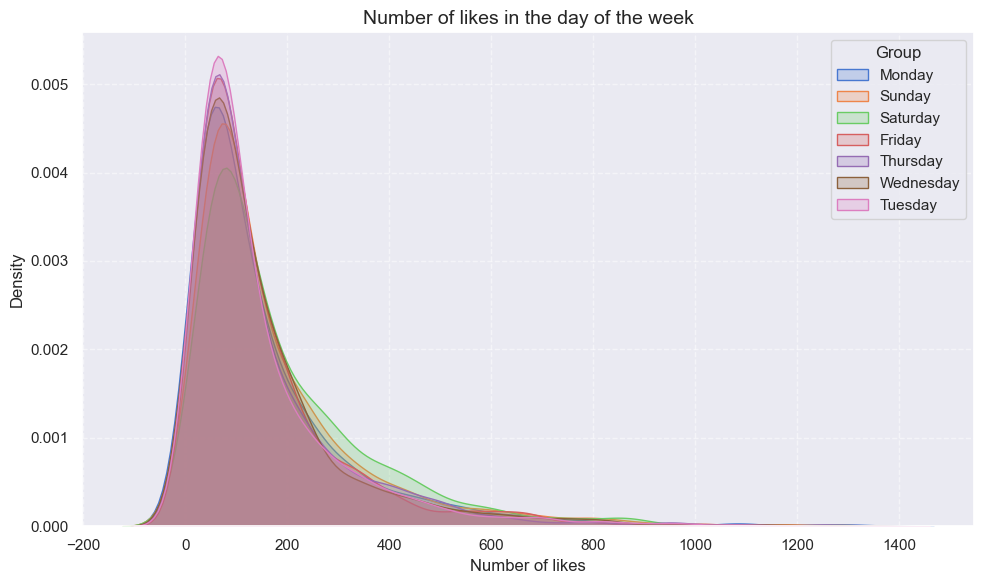

In [267]:
plot_distributions(data=day_of_the_week_likes_arr, title="Number of likes in the day of the week",
                   xlabel="Number of likes", ylabel="Density")

### Statistical test

In [268]:
day_of_the_week_likes_test = MultipleSampleStatisticalTests(datasets=day_of_the_week_likes_arr.values(), significance_level=SIGNIFICANCE_LEVEL)
day_of_the_week_likes_test.test_multiple_samples()

Normality p-value (residuals): 0.0
Variance homogeneity p-value: 1.2055419183675585e-06
Kruskal-Wallis test was chosen
Final p-value: 2.1947523157173017e-25
H0 has been rejected, Ha has been accepted


### Key takeaway

## Key takeaways

# Statistical testing of number of comments

In this chapter we conduct statistical testing on the hypothesises of mean's equality between splits on predefined features in `number_of_comments`

The following instruments were used:
- **shapiro** or **normaltest** for normality check
- **levene** test for check for homogeneity of variances  
- **t-test** or **Mann U Whitney test** for two sample means comparison  
- **ANOVA** or **Kruskal-Wallis test** for several sample means comparison

## International vs local in comments

In [269]:
all_comments = extract_target_feature(df=final_cleaned_df, split_feature="type", target_feature="number_of_comments")
all_comments

{'international': array([3, 0, 1, ..., 1, 9, 0]),
 'local': array([0, 1, 0, ..., 2, 0, 1])}

### Visualization of distributions

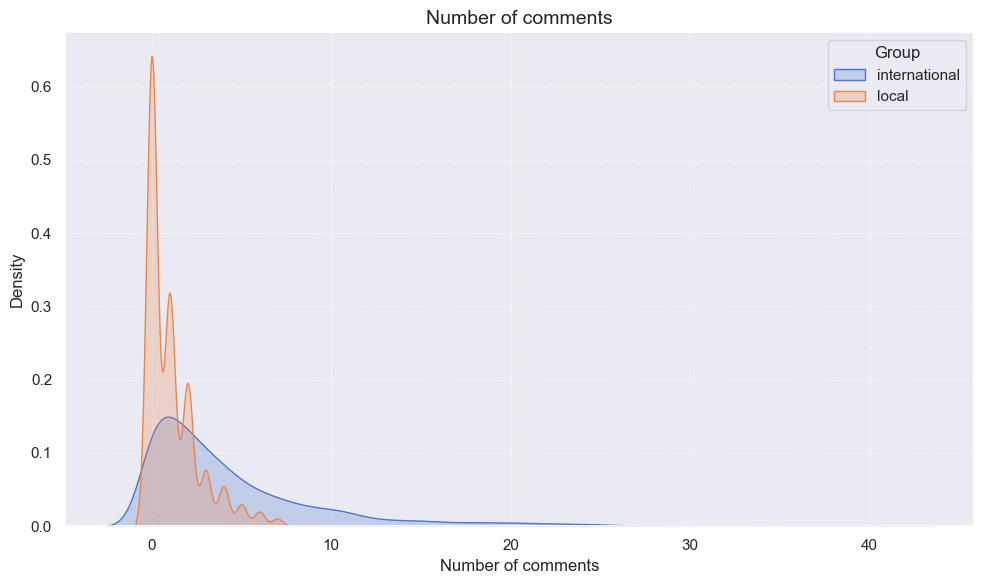

In [270]:
plot_distributions(data=all_comments, title="Number of comments", xlabel="Number of comments", ylabel="Density")

### Statistical test 

In [271]:
local_comments, international_comments = all_comments['local'], all_comments['international']
len(local_comments), len(international_comments)

(3164, 15372)

In [272]:
comments_test = TwoSampleStatisticalTests(first_dataset=international_comments, second_dataset=local_comments,
                                          significance_level=SIGNIFICANCE_LEVEL)
comments_test.test_two_numerical_samples(is_one_tailed=True)

The result of the p-value when checking the normality for the first dataset: 0.0
The result of the p-value when checking the normality for the second dataset: 3.069884198974372e-56
The result of the p-value when checking the variance uniform: 2.336916423549894e-192
Mann-Whitney was chosen
Final p-value: 0.0
H0 has been rejected, Ha has been accepted


### Key takeaway

## Peak vs non-peak in comments (international)

In [273]:
peak_comments_arr = extract_target_feature(df=international_df, split_feature="is_peak",
                                           target_feature="number_of_comments")
peak_comments_arr

{False: array([3, 0, 1, ..., 1, 1, 0]),
 True: array([ 8, 21,  5, ...,  4,  1,  9])}

### Visualization of distributions

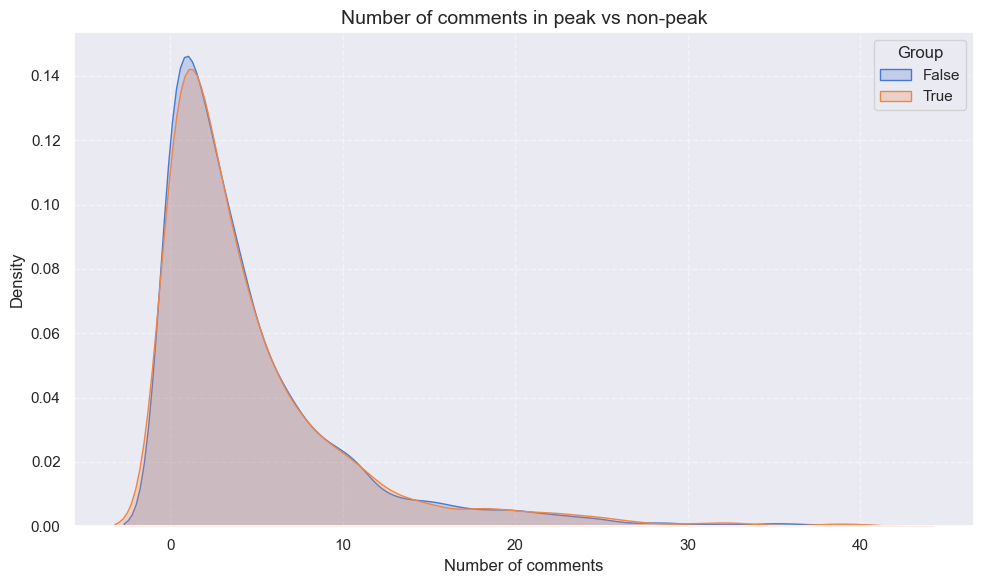

In [274]:
plot_distributions(data=peak_comments_arr, title="Number of comments in peak vs non-peak", xlabel="Number of comments",
                   ylabel="Density")

### Statistical test

In [275]:
peak_comments, non_peak_comments = peak_comments_arr[True], peak_comments_arr[False]
len(peak_comments), len(non_peak_comments)

(4873, 10499)

In [276]:
peak_comments_test = TwoSampleStatisticalTests(first_dataset=peak_comments, second_dataset=non_peak_comments,
                                               significance_level=SIGNIFICANCE_LEVEL)
peak_comments_test.test_two_numerical_samples(is_one_tailed=True)

The result of the p-value when checking the normality for the first dataset: 1.7089727812354606e-66
The result of the p-value when checking the normality for the second dataset: 0.0
The result of the p-value when checking the variance uniform: 0.46673565918307336
Mann-Whitney was chosen
Final p-value: 0.4278492090928451
H0 was not rejected


### Key takeaway

## Collaboration presence in comments (international)

In [277]:
collaboration_comments_arr = extract_target_feature(df=international_df, split_feature="is_collaboration",
                                                    target_feature="number_of_comments")
collaboration_comments_arr

{False: array([3, 0, 1, ..., 1, 9, 0]),
 True: array([11,  3,  1,  5,  4,  7,  1,  0,  0,  1,  2,  0,  4,  4,  9,  0,  3,
         2,  5, 22,  4])}

### Visualization of distributions

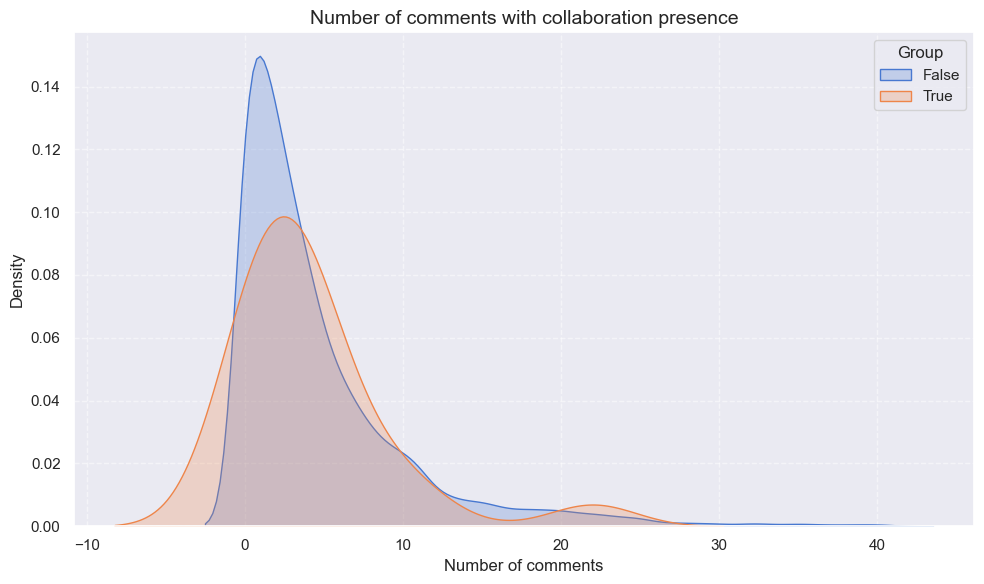

In [278]:
plot_distributions(data=collaboration_comments_arr, title="Number of comments with collaboration presence",
                   xlabel="Number of comments", ylabel="Density")

### Statistical test

In [279]:
collab_comments, non_collab_comments = collaboration_comments_arr[True], collaboration_comments_arr[False]
len(collab_comments), len(non_collab_comments)

(21, 15351)

In [280]:
collab_comments_test = TwoSampleStatisticalTests(first_dataset=collab_comments, second_dataset=non_collab_comments,
                                                 significance_level=SIGNIFICANCE_LEVEL)
collab_comments_test.test_two_numerical_samples(is_one_tailed=True)

The result of the p-value when checking the normality for the first dataset: 9.086598935580563e-05
The result of the p-value when checking the normality for the second dataset: 0.0
The result of the p-value when checking the variance uniform: 0.6066690838560844
Mann-Whitney was chosen
Final p-value: 0.5711295515422219
H0 was not rejected


### Key takeaway

## Weekend vs weekday in comments (international)

In [281]:
weekend_comments_arr = extract_target_feature(df=international_df, split_feature="is_weekend",
                                              target_feature="number_of_comments")
weekend_comments_arr

{False: array([ 3,  5, 17, ...,  1,  9,  0]),
 True: array([ 0,  1,  0, ...,  1,  0, 11])}

### Visualization of distributions

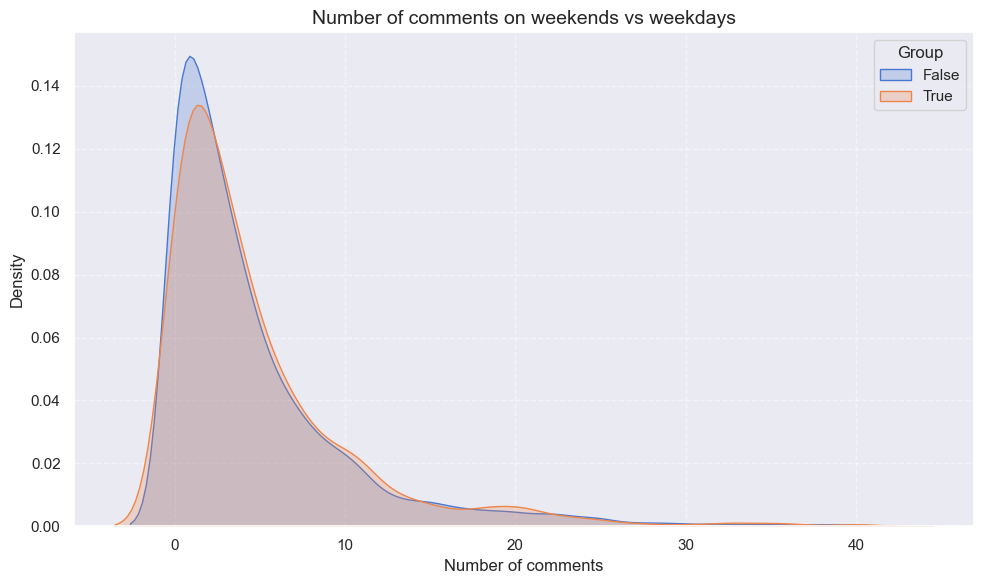

In [282]:
plot_distributions(data=weekend_comments_arr, title="Number of comments on weekends vs weekdays",
                   xlabel="Number of comments", ylabel="Density")

### Statistical test

In [283]:
weekend_comments, weekday_comments = weekend_comments_arr[True], weekend_comments_arr[False]
len(weekend_comments), len(weekday_comments)

(3144, 12228)

In [284]:
weekend_comments_test = TwoSampleStatisticalTests(first_dataset=weekend_comments, second_dataset=weekday_comments,
                                                  significance_level=SIGNIFICANCE_LEVEL)
weekend_comments_test.test_two_numerical_samples(is_one_tailed=True)

The result of the p-value when checking the normality for the first dataset: 6.570683700749303e-57
The result of the p-value when checking the normality for the second dataset: 0.0
The result of the p-value when checking the variance uniform: 0.3519906556832315
Mann-Whitney was chosen
Final p-value: 0.0005595285318095996
H0 has been rejected, Ha has been accepted


### Key takeaway

## Content type in comments (international)

In [285]:
content_type_comments_arr = extract_target_feature(df=international_df, split_feature="is_photo",
                                                   target_feature="number_of_comments")
content_type_comments_arr

{False: array([ 3,  1,  6,  5,  1,  0, 16,  5,  2, 17,  2, 10,  4, 11, 13,  8, 21,
        18, 10,  3,  4,  5, 22, 13,  3,  7, 13,  4, 11, 20,  1, 13, 21, 20,
        21,  4, 11,  5,  6, 16, 12, 30, 26, 21,  4,  3, 10,  3,  9, 27, 23,
         7,  2,  5,  4,  4, 11, 13, 10, 11, 31,  9,  9,  7,  5,  7,  0,  1,
        25,  8,  3, 22,  5, 33,  5, 18, 41,  7, 35,  5, 10, 11, 12,  8,  8,
         4,  5, 19,  5,  9, 34,  6,  8, 14, 28, 10, 15, 22, 27,  3, 16, 16,
         2,  9, 31,  5, 21,  6,  5,  3,  6, 17, 18,  5, 20, 20, 14, 10,  2,
        11,  5, 13,  7,  8,  8,  9, 14, 10,  9, 12, 10, 19, 15,  8,  8, 14,
         4,  8, 35,  6, 12,  7,  4, 24,  8, 18,  3, 14, 20, 15, 11, 13,  9,
        27, 18,  8, 10,  5,  9,  8, 10, 32, 13,  8, 27, 39, 35, 11, 22, 11,
        27, 22, 12, 10,  7, 24,  9, 11, 12,  8, 29, 25,  2, 11,  3,  3, 11,
         5,  1, 12,  7, 10, 18,  4, 10, 10, 38,  2, 10, 39, 19,  2, 30,  2,
        15, 29,  4, 13, 24,  2,  1, 16,  8,  4, 12,  4, 24,  7, 14,  6, 10,
     

### Visualization of distributions

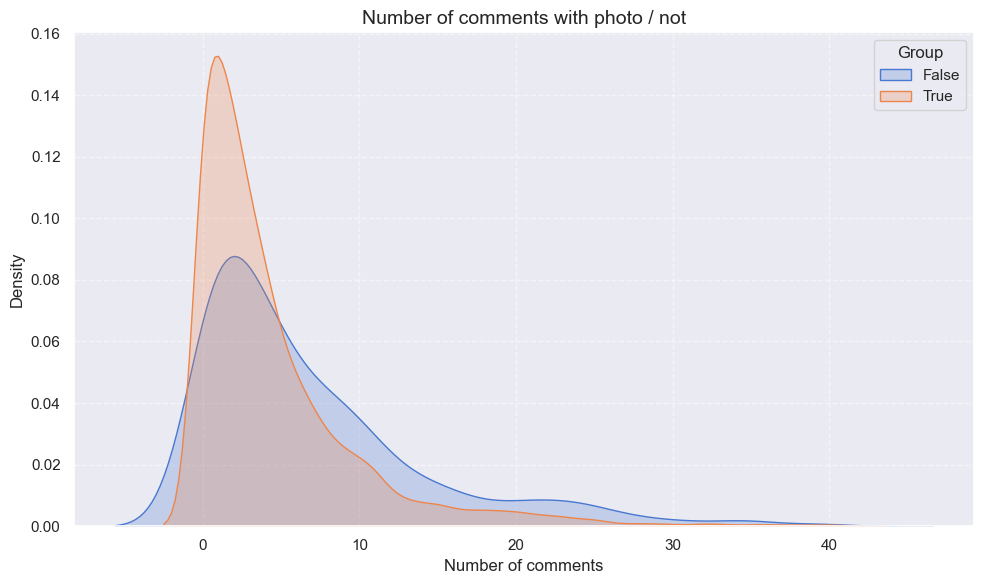

In [286]:
plot_distributions(data=content_type_comments_arr, title="Number of comments with photo / not",
                   xlabel="Number of comments", ylabel="Density")

### Statistical test

In [287]:
photo_comments, video_comments = content_type_comments_arr[True], content_type_comments_arr[False]
len(photo_comments), len(video_comments)

(14412, 960)

In [288]:
reel_comments_test = TwoSampleStatisticalTests(first_dataset=video_comments, second_dataset=photo_comments,
                                               significance_level=SIGNIFICANCE_LEVEL)
reel_comments_test.test_two_numerical_samples(is_one_tailed=True)

The result of the p-value when checking the normality for the first dataset: 1.2040967562162903e-31
The result of the p-value when checking the normality for the second dataset: 0.0
The result of the p-value when checking the variance uniform: 6.732251668715751e-26
Mann-Whitney was chosen
Final p-value: 6.625943573231587e-28
H0 has been rejected, Ha has been accepted


### Key takeaway

## Personal words in comments (international)

In [289]:
personal_words_comments_arr = extract_target_feature(df=international_df, split_feature="has_personal_words",
                                                  target_feature="number_of_comments")
personal_words_comments_arr

{True: array([3, 0, 1, ..., 1, 9, 0]), False: array([6, 5, 0, ..., 0, 0, 1])}

### Visualization of distributions

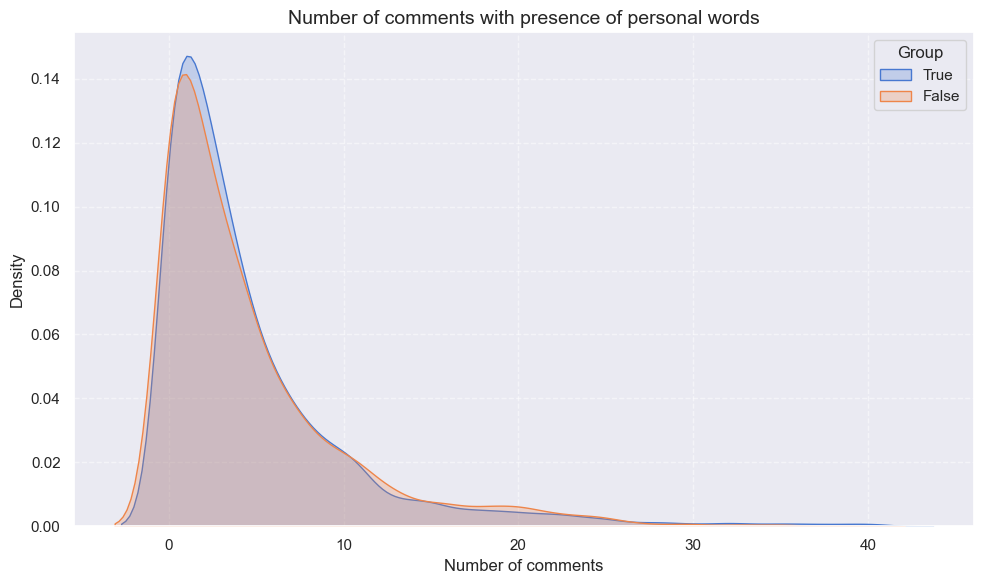

In [290]:
plot_distributions(data=personal_words_comments_arr, title="Number of comments with presence of personal words",
                   xlabel="Number of comments", ylabel="Density")

### Statistical test

In [291]:
personal_words_comments, non_personal_words_comments = personal_words_comments_arr[True], personal_words_comments_arr[False]
len(personal_words_comments), len(non_personal_words_comments)

(10939, 4433)

In [292]:
personal_comments_test = TwoSampleStatisticalTests(first_dataset=personal_words_comments,
                                                second_dataset=non_personal_words_comments,
                                                significance_level=SIGNIFICANCE_LEVEL)
personal_comments_test.test_two_numerical_samples(is_one_tailed=True)

The result of the p-value when checking the normality for the first dataset: 0.0
The result of the p-value when checking the normality for the second dataset: 9.06517579179728e-62
The result of the p-value when checking the variance uniform: 0.5795011536720736
Mann-Whitney was chosen
Final p-value: 0.033079105025107323
H0 has been rejected, Ha has been accepted


### Key takeaway

## Length of the posts in comments (international)

In [293]:
length_post_comments_arr = extract_target_feature(df=international_df, split_feature="is_above_avg_length",
                                                  target_feature="number_of_comments")
length_post_comments_arr

{True: array([3, 0, 0, ..., 0, 0, 1]),
 False: array([ 1, 17,  6, ...,  1,  9,  0])}

### Visualization of distributions

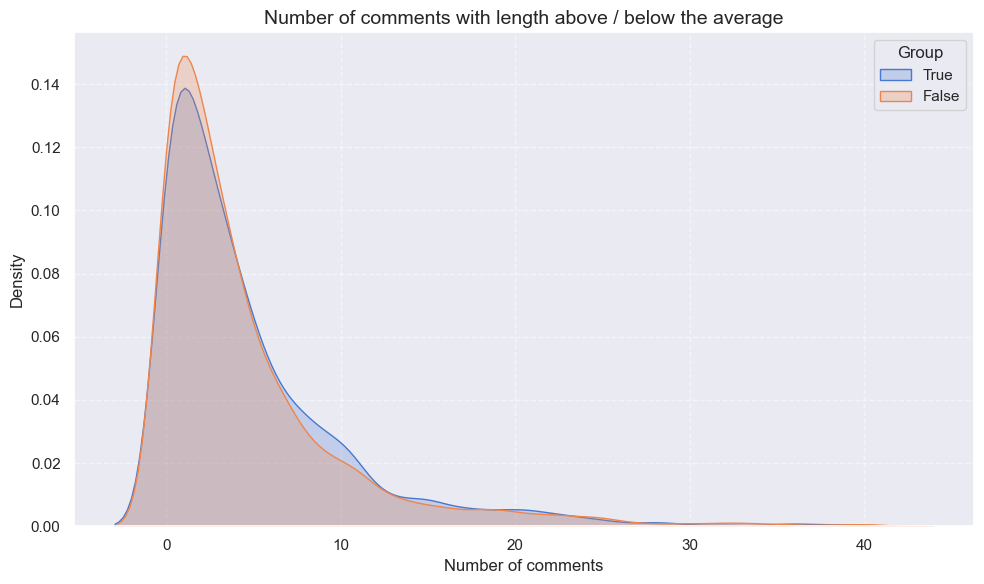

In [294]:
plot_distributions(data=length_post_comments_arr, title="Number of comments with length above / below the average",
                   xlabel="Number of comments", ylabel="Density")

### Statistical test

In [295]:
above_avg_length_comments, below_avg_length_comments = length_post_comments_arr[True], length_post_comments_arr[False]
len(above_avg_length_comments), len(below_avg_length_comments)

(6354, 9018)

In [296]:
length_likes_test = TwoSampleStatisticalTests(first_dataset=above_avg_length_comments,
                                                second_dataset=above_avg_length_comments,
                                                significance_level=SIGNIFICANCE_LEVEL)
length_likes_test.test_two_numerical_samples(is_one_tailed=True)

The result of the p-value when checking the normality for the first dataset: 0.0
The result of the p-value when checking the normality for the second dataset: 0.0
The result of the p-value when checking the variance uniform: 1.0
Mann-Whitney was chosen
Final p-value: 0.5000009708330484
H0 was not rejected


### Key takeaway

## Day of the week in comments (international)

In [297]:
day_of_the_week_comments_arr = extract_target_feature(df=international_df, split_feature="day_of_the_week",
                                                  target_feature="number_of_comments")
day_of_the_week_comments_arr

{'Monday': array([3, 5, 0, ..., 2, 5, 4]),
 'Sunday': array([0, 1, 2, ..., 0, 1, 0]),
 'Saturday': array([ 0,  1,  0, ...,  6,  0, 11]),
 'Friday': array([ 5, 16,  5, ...,  1,  0,  1]),
 'Thursday': array([17, 28,  4, ...,  2,  2,  0]),
 'Wednesday': array([6, 2, 3, ..., 6, 1, 1]),
 'Tuesday': array([17,  6, 11, ...,  5,  9,  0])}

### Visualization of distributions

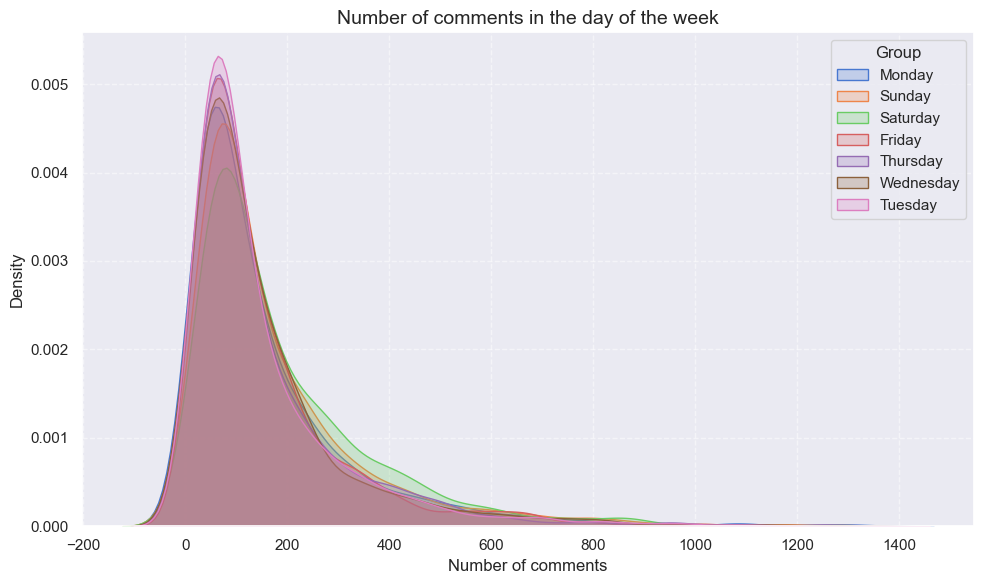

In [298]:
plot_distributions(data=day_of_the_week_likes_arr, title="Number of comments in the day of the week",
                   xlabel="Number of comments", ylabel="Density")

### Statistical test

In [299]:
day_of_the_week_comments_test = MultipleSampleStatisticalTests(datasets=day_of_the_week_comments_arr.values(), significance_level=SIGNIFICANCE_LEVEL)
day_of_the_week_comments_test.test_multiple_samples()

Normality p-value (residuals): 0.0
Variance homogeneity p-value: 0.39903160983094155
Kruskal-Wallis test was chosen
Final p-value: 0.0034956481505675715
H0 has been rejected, Ha has been accepted


### Key takeaway

## Key takeaways

# Multi-level regression analysis